# Predicting Failures with ML

### Introduction
The ongoing challenge in maintenance is identifying and minimizing failures in operational equipment. Predictive maintenance has emerged as a key technique to address this issue, involving continuous monitoring, tracking, and inspection of machinery to gather data on equipment wear and degradation. This data enables timely maintenance, preventing failures and extending the overall lifespan of the equipment.

However, determining the optimal moment to halt equipment operation remains a crucial question. To address this, we aim to develop a machine learning algorithm capable of predicting equipment failures in advance. This predictive model will enhance the efficiency of maintenance activities by enabling interventions before failures occur.

In [125]:
# Import libraries
import pandas as pd
import warnings
import numpy as np
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import math
import datetime
from IPython.display import Image
import  matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import seaborn as sns
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import recall_score, f1_score, roc_auc_score, confusion_matrix,classification_report, accuracy_score, precision_score
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_curve, auc
import optuna
from imblearn.under_sampling import RandomUnderSampler

Downlaod data from https://www.kaggle.com/datasets/hiimanshuagarwal/predictive-maintenance-dataset?resource=download

Analysing with the help of : https://www.kaggle.com/code/ahmettalhabektas/proactive-maintenance-predicting-failures-with-ml and
https://www.kaggle.com/code/igones/device-failure-predict-roc-auc-82

In [126]:
# Import data
df = pd.read_csv('/Users/moni/DS - Karan/Week5/Data/predictive_maintenance_dataset.csv', dtype={'column_name': str}, low_memory=False)
df.head()

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
0,1/1/2015,S1F01085,0,215630672,55,0,52,6,407438,0,0,7
1,1/1/2015,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,1/1/2015,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,1/1/2015,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,1/1/2015,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


## Data cleaning and pre-processing

In [127]:
# Dataframe discription
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 12 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   date     124494 non-null  object
 1   device   124494 non-null  object
 2   failure  124494 non-null  int64 
 3   metric1  124494 non-null  int64 
 4   metric2  124494 non-null  int64 
 5   metric3  124494 non-null  int64 
 6   metric4  124494 non-null  int64 
 7   metric5  124494 non-null  int64 
 8   metric6  124494 non-null  int64 
 9   metric7  124494 non-null  int64 
 10  metric8  124494 non-null  int64 
 11  metric9  124494 non-null  int64 
dtypes: int64(10), object(2)
memory usage: 11.4+ MB
None


The dataset has a total of 11 variables, the target variable (failure), feature Variables consisting of 9 sensors in numeric format, the data variable in object format requiring conversion to datetime, and a device variable in categorical format.

In [128]:
pd.set_option('display.float_format', '{:.2f}'.format)
df.describe()

,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
count,124494.00,124494.00,124494.00,124494.00,124494.00,124494.00,124494.00,124494.00,124494.00,124494.00
mean,0.00,122388103.24,159.49,9.94,1.74,14.22,260172.66,0.29,0.29,13.01
std,0.03,70459334.22,2179.68,185.75,22.91,15.94,99151.08,7.44,7.44,275.66
min,0.00,0.00,0.00,0.00,0.00,1.00,8.00,0.00,0.00,0.00
25%,0.00,61284762.00,0.00,0.00,0.00,8.00,221452.00,0.00,0.00,0.00
50%,0.00,122797388.00,0.00,0.00,0.00,10.00,249799.50,0.00,0.00,0.00
75%,0.00,183309640.00,0.00,0.00,0.00,12.00,310266.00,0.00,0.00,0.00
max,1.00,244140480.00,64968.00,24929.00,1666.00,98.00,689161.00,832.00,832.00,70000.00


## Explor dataset

### Date

In [129]:
# Convert the 'date_column' to datetime format
df['date'] = pd.to_datetime(df['date'])

# Find the minimum and maximum dates
min_date = df['date'].min()
max_date = df['date'].max()

print(f"Minimum Date: {min_date}")
print(f"Maximum Date: {max_date}")

Minimum Date: 2015-01-01 00:00:00
Maximum Date: 2015-11-02 00:00:00


In [130]:
# Unique valuese for date
unique_dates = df['date'].unique()
print("Unique Dates:", unique_dates)

Unique Dates: <DatetimeArray>
['2015-01-01 00:00:00', '2015-01-02 00:00:00', '2015-01-03 00:00:00',
 '2015-01-04 00:00:00', '2015-01-05 00:00:00', '2015-01-06 00:00:00',
 '2015-01-07 00:00:00', '2015-01-08 00:00:00', '2015-01-09 00:00:00',
 '2015-01-10 00:00:00',
 ...
 '2015-10-22 00:00:00', '2015-10-23 00:00:00', '2015-10-24 00:00:00',
 '2015-10-25 00:00:00', '2015-10-26 00:00:00', '2015-10-27 00:00:00',
 '2015-10-29 00:00:00', '2015-10-30 00:00:00', '2015-10-31 00:00:00',
 '2015-11-02 00:00:00']
Length: 304, dtype: datetime64[ns]


In [131]:
# The data is recorded in 304 different days between 01.01.2015 to 02.11.2015

### Device

In [132]:
unique_devices = df['device'].nunique()
print("The number of Unique devices are:", unique_devices)

The number of Unique devices are: 1169


### Failure

In [133]:
unique_failure = df['failure'].nunique()
print("The number of failure:", unique_failure)

The number of failure: 2


In [134]:
# Finding null values
df.isnull().sum()

date       0
device     0
failure    0
metric1    0
metric2    0
metric3    0
metric4    0
metric5    0
metric6    0
metric7    0
metric8    0
metric9    0
dtype: int64

It looks like there's a specific structure in the 'device' information. To extract the TAG from 'device,' we need to know the company's standard. This helps in correctly identifying the sector, equipment category, and the unique equipment identifier. Since we lack access to this standard, we'll split the 'devices' variable into two parts. The first part will include the initial four values, indicating the installation sector, and the second part will consist of the remaining characters, indicating the equipment type. This way, we can work with these separate features without knowing the exact company standard.
Ans also we create the the day, month, year, day of the week and week of the month from the date column.

In [135]:
# Date features
df_devices = df.copy()
df_devices['day'] = df_devices['date'].dt.day
df_devices['month'] = df_devices['date'].dt.month
df_devices['year'] = df_devices['date'].dt.year
df_devices['day_of_week'] = df_devices['date'].dt.weekday
df_devices['week_of_month'] = (df_devices['day'] - 1) // 7 + 1
    
# Devices features
df_devices['sector'] = df_devices['device'].str[:4]
df_devices['equipment'] = df_devices['device'].str[4:]
df_devices

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9,day,month,year,day_of_week,week_of_month,sector,equipment
0,2015-01-01,S1F01085,0,215630672,55,0,52,6,407438,0,0,7,1,1,2015,3,1,S1F0,1085
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0,1,1,2015,3,1,S1F0,166B
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0,1,1,2015,3,1,S1F0,1E6Y
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0,1,1,2015,3,1,S1F0,1JE0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3,1,1,2015,3,1,S1F0,1R2B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124489,2015-11-02,Z1F0MA1S,0,18310224,0,0,0,10,353705,8,8,0,2,11,2015,0,1,Z1F0,MA1S
124490,2015-11-02,Z1F0Q8RT,0,172556680,96,107,4,11,332792,0,0,13,2,11,2015,0,1,Z1F0,Q8RT
124491,2015-11-02,Z1F0QK05,0,19029120,4832,0,0,11,350410,0,0,0,2,11,2015,0,1,Z1F0,QK05
124492,2015-11-02,Z1F0QL3N,0,226953408,0,0,0,12,358980,0,0,0,2,11,2015,0,1,Z1F0,QL3N


In [136]:
# Check unique values
df_devices.nunique()

date                304
device             1169
failure               2
metric1          123877
metric2             560
metric3              48
metric4             115
metric5              60
metric6           44838
metric7              28
metric8              28
metric9              67
day                  31
month                11
year                  1
day_of_week           7
week_of_month         5
sector                7
equipment          1169
dtype: int64

## Exploratory Data Analysis (EDA)

### The distribution of failures

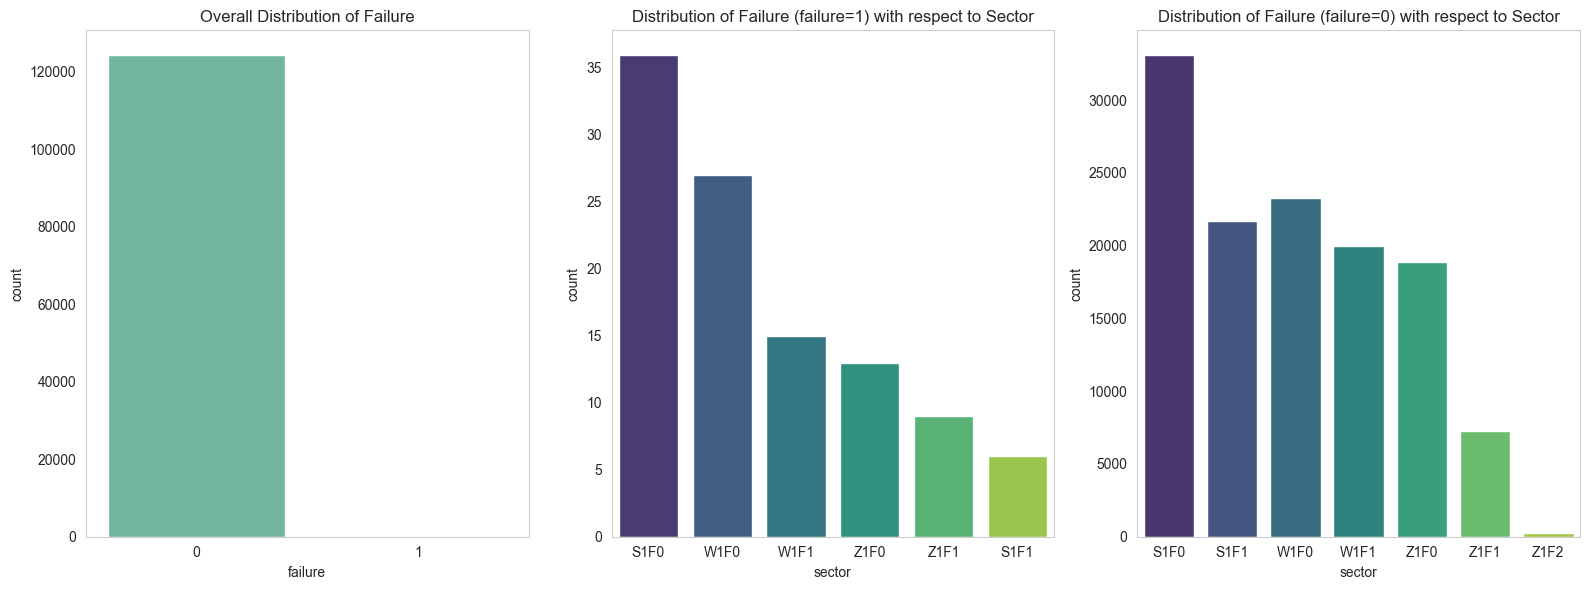

In [137]:
plt.figure(figsize=(16, 6))

# Overal distribution of failure
plt.subplot(1, 3, 1)
sns.countplot(x='failure', data=df_devices, palette='Set2')
plt.title('Overall Distribution of Failure')

# Plot the distribution of 'failure' with respect to 'device' for failure=1
plt.subplot(1, 3, 2)
sns.countplot(x="sector", data=df_devices.loc[df_devices["failure"] == 1], palette='viridis')
plt.title('Distribution of Failure (failure=1) with respect to Sector')

# Plot the distribution of 'failure' with respect to 'device' for failure=0
plt.subplot(1, 3, 3)
sns.countplot(x="sector", data=df_devices.loc[df_devices["failure"] == 0], palette='viridis')
plt.title('Distribution of Failure (failure=0) with respect to Sector')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

The first graph indicates that there are way more instances of normal data (0) than failures. To address this imbalance, we plan to balance the classes in this target variable.
Since failures are quite rare, we're checking if every 'device' listed has experienced a failure. This helps us understand the distribution of failures among the devices.

In [138]:
df_devices[df_devices['failure'] == 1].device.nunique()

106

Out of the 1169 devices in the dataset, only 106 (about 9%) have experienced failures. With such a small percentage of failures, it's possible that some devices were replaced or exchanged over time. To explore this, we'll investigate the distribution of 'devices' over time in the dataset and check whether the devices that failed have been present in the dataset since the beginning.

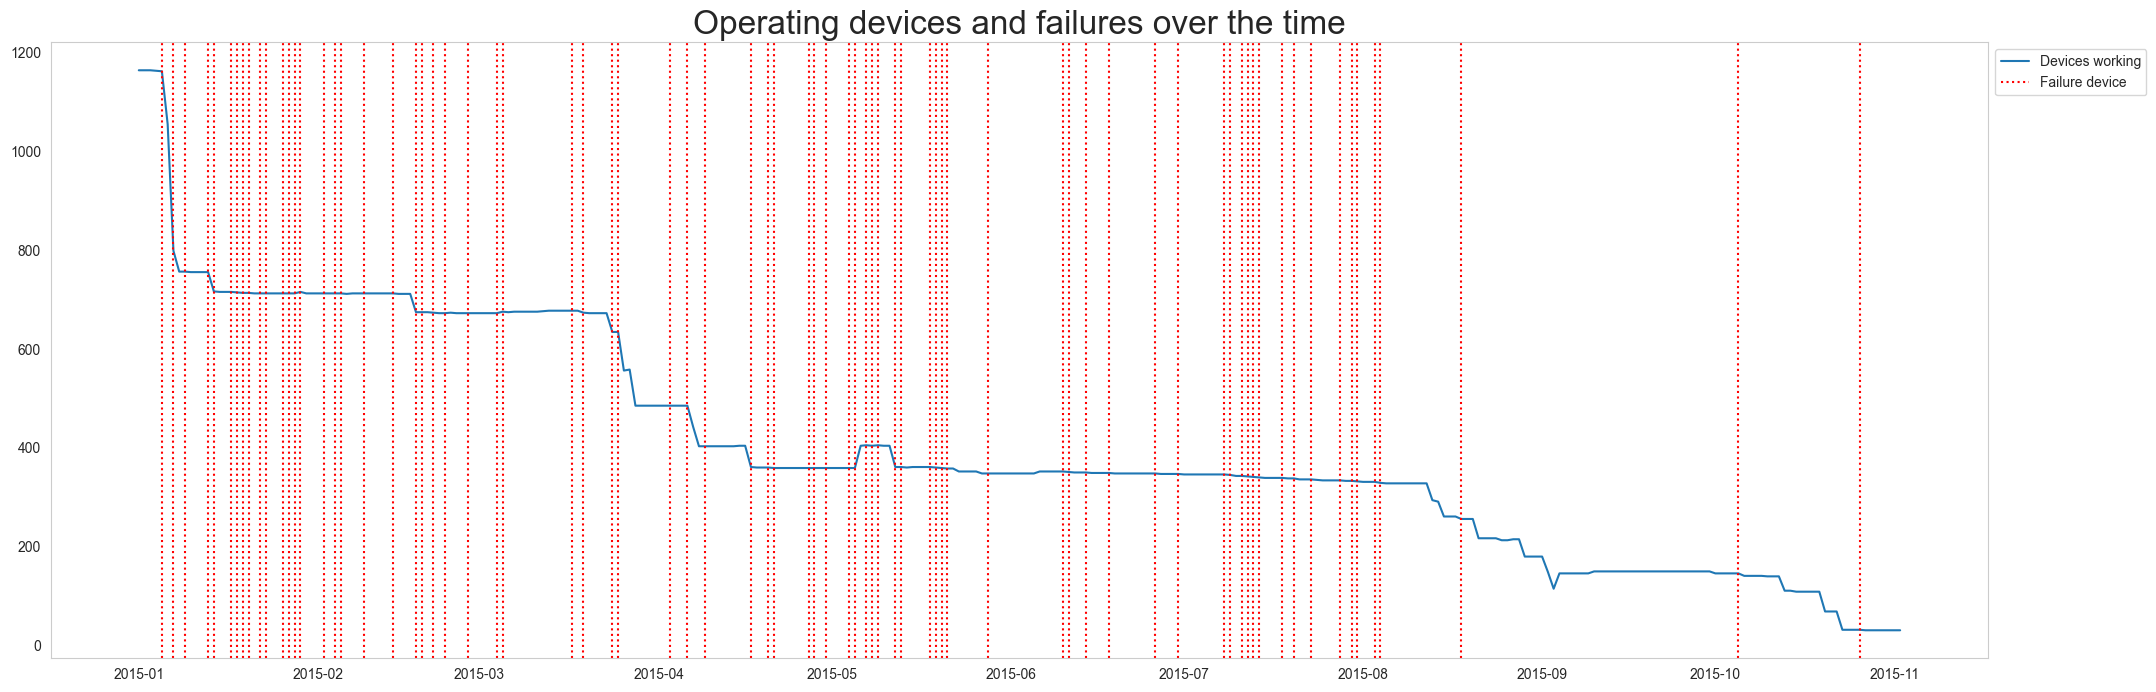

In [139]:
df_devices_group = df_devices.groupby('date').agg(count_devices = ('device','count'), failure = ('failure','max'))
fig, ax = plt.subplots(figsize=(25,8))
plt.plot(df_devices_group.index,df_devices_group['count_devices'], label = 'Devices working')

idx = df_devices_group[df_devices_group['failure'] == 1].index
for i in range(len(idx)-2):
    plt.axvline(x =idx[i],linestyle =  'dotted', color = 'r')
plt.grid(False)    
plt.title('Operating devices and failures over the time', fontsize=24)   
plt.axvline(x = idx[-1], color = 'r',linestyle ='dotted', label = 'Failure device')
plt.legend(bbox_to_anchor = (1.0, 1), loc = 'upper left')
plt.show()

#### Observation:
There's a noticeable decrease in the number of operational equipment, especially from January to February. Surprisingly, days with device failures don't seem to align with a decrease in operational equipment.

Additionally, there are only two periods of significant increase in device numbers, one at the start of May and another at the beginning of September. Interestingly, the number of devices at the beginning of January matches the total in the dataset. This suggests that no new equipment was added over time, but some devices may have stopped working or experienced a rotation in operation.

As the number of devices decreased after the August, we can see that the failure is also decreasing.

-------------------------------------------------------------------------------------------------------------






Since the exact time of metric collection regarding the failure occurrence is unspecified, assumptions are made. It is assumed that the failure will be recorded on the day following the metric measurement. This assumption is made to account for scenarios where metrics are collected either on the day before the failure, when the equipment is on the verge of failure, or under other decisive conditions for constructing the prediction model.

Given these considerations, the planned model will operate on a one-day advance basis. This means that the model aims to predict failures one day in advance, allowing for the proactive halting and maintenance of equipment at least one day before an anticipated failure.

A variable will be created to count the number of days worked by each device and another variable to count how many times the equipment was turned on again.

In [140]:
df_devices['op_period'] = 0
df_devices['dev_reconnected'] = 0
device_list = df_devices['device'].unique()
for x in device_list:
    idx = df_devices['device'] == x  
    aux = np.sum(idx)
    aux2 = range(1,aux+1)
    df_devices.loc[idx,'op_period'] = aux2
    
    idx2 = df_devices[idx].index
    for i in range(0,len(idx2)-1):
        aux = (df_devices.loc[idx2[i],'date'])+datetime.timedelta(days=1)
        aux2 =(df_devices.loc[idx2[i+1],'date'])
        if aux != aux2:
            df_devices.loc[idx2[i+1],'dev_reconnected'] = df_devices.loc[idx2[i],'dev_reconnected']+1
        else:
            df_devices.loc[idx2[i+1],'dev_reconnected'] = df_devices.loc[idx2[i],'dev_reconnected']
df_devices.tail(5)

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,...,metric9,day,month,year,day_of_week,week_of_month,sector,equipment,op_period,dev_reconnected
124489,2015-11-02,Z1F0MA1S,0,18310224,0,0,0,10,353705,8,...,0,2,11,2015,0,1,Z1F0,MA1S,304,2
124490,2015-11-02,Z1F0Q8RT,0,172556680,96,107,4,11,332792,0,...,13,2,11,2015,0,1,Z1F0,Q8RT,304,2
124491,2015-11-02,Z1F0QK05,0,19029120,4832,0,0,11,350410,0,...,0,2,11,2015,0,1,Z1F0,QK05,304,2
124492,2015-11-02,Z1F0QL3N,0,226953408,0,0,0,12,358980,0,...,0,2,11,2015,0,1,Z1F0,QL3N,304,2
124493,2015-11-02,Z1F0QLC1,0,17572840,0,0,0,10,351431,0,...,70000,2,11,2015,0,1,Z1F0,QLC1,304,2


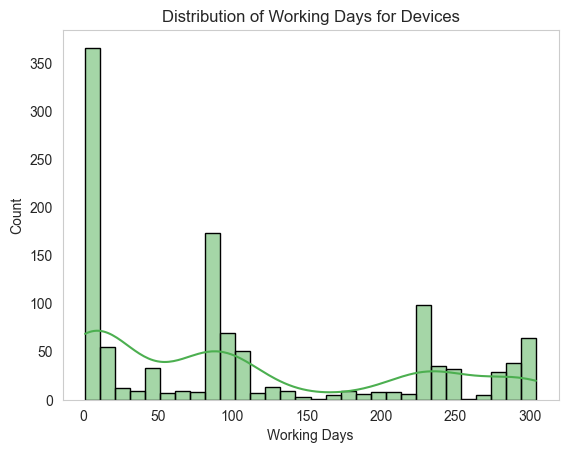

In [141]:
df_devices_group = df_devices.groupby('device').agg(days_work = ('op_period','max'))
sns.histplot(data = df_devices_group,x = 'days_work', bins = 30, kde=True, color='#4CAF50', edgecolor='black')
plt.xlabel('Working Days')
plt.grid(False)
plt.title('Distribution of Working Days for Devices')
plt.show()

#### Observation
- more than 350 devices have less than 10 working days. 
- two more concentrations are notable, one of them with working time between 80 to 90 days and the other with working time between 230 and 240 days.
- Approximately 60 devices have between 290 and 304 days in operation in the dataset.

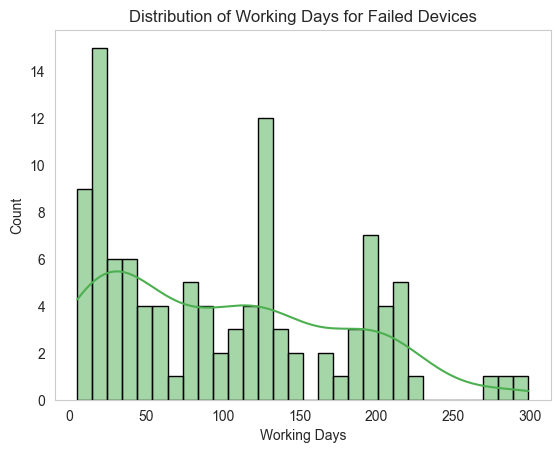

In [142]:
df_devices_group = df_devices[df_devices['failure'] == 1].groupby('device').agg(days_work = ('op_period','max'))
sns.histplot(data = df_devices_group,x = 'days_work', bins = 30, kde=True, color='#4CAF50', edgecolor='black')
plt.xlabel('Working Days')
plt.grid(False)
plt.title('Distribution of Working Days for Failed Devices')
plt.show()

#### Observation
- two concentrations: one of them between 10 and 20 days of operation and the other between 120 and 130 days.

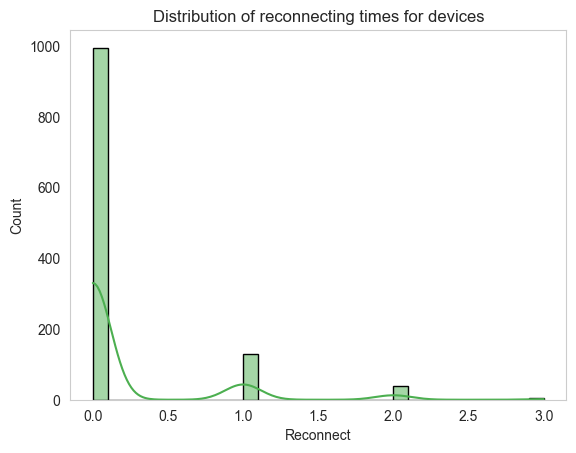

In [143]:
df_devices_group = df_devices.groupby('device').agg(reconnect = ('dev_reconnected','max'))
sns.histplot(data = df_devices_group,x = 'reconnect', bins = 30, kde=True, color='#4CAF50', edgecolor='black')
plt.xlabel('Reconnect')
plt.grid(False)
plt.title('Distribution of reconnecting times for devices')
plt.show()

#### Observation
- most equipment was only turned on once and that they were turned on up to 3 times at most. This may indicate that, in most cases, equipment was replaced instead of alternating between them.

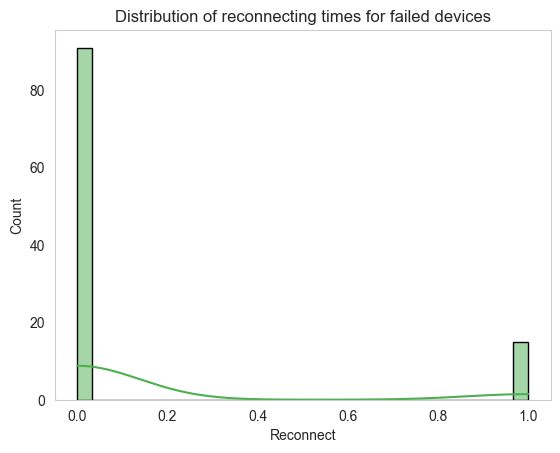

In [144]:
df_devices_group = df_devices[df_devices['failure'] == 1].groupby('device').agg(reconnect = ('dev_reconnected','max'))
sns.histplot(data = df_devices_group,x = 'reconnect', bins = 30, kde=True, color='#4CAF50', edgecolor='black')
plt.xlabel('Reconnect')
plt.grid(False)
plt.title('Distribution of reconnecting times for failed devices')
plt.show()

#### Observation
- The majority of devices was only turned on once and at the most reconnected once, indicating that in most cases the device was replaced and that in a few cases the equipment was repaired and it was put to work again.

In [145]:
df_devices[df_devices['op_period']>303].device.count()

27

Only 27 decises operated in 304 days.

### Metrics - feature engineering

#### Metric1

In [146]:
df_devices['metric1'].sort_values().head(600).unique()

array([      0,    2048,    2056,    2168,    3784,    4224,    4480,
          4560,    8280,    8616,    9088,    9472,   11480,   12776,
         13824,   15928,   17272,   18800,   19120,   23840,   26624,
         28568,   30088,   35544,   37680,   40208,   41000,   43016,
         43888,   45088,   45216,   47288,   47472,   47528,   48128,
         48152,   48384,   49272,   49792,   50128,   50584,   50696,
         52664,   53184,   54040,   60192,   61208,   72808,   75736,
         76200,   78120,   79240,   89968,   90528,   95216,   96024,
         96264,   96272,   96968,   97848,   98736,  100920,  101640,
        112376,  112760,  123608,  124768,  125456,  127088,  127384,
        132096,  132832,  134568,  142720,  144368,  151600,  152520,
        155968,  156120,  157792,  163912,  167408,  172112,  172696,
        172984,  176912,  177520,  178568,  183192,  183760,  188416,
        192576,  194072,  196064,  198760,  199312,  199672,  200144,
        202056,  207

In metric 1, apparently all values are divisible by 8, but as the visualization of unique values is not complete, a multiplicity check will be performed to then carry out the division.

In [147]:
def multi(x,i):
    if x%i == 0:
        return True
    else:
        return False
    
a = df_devices['metric1'].apply(lambda x: multi(x,8))
a[a == False].count()

46

Out of the 124,494 data points in metric 1, only 46 are not multiples of 8. Since this is a small portion, and considering these might be measurement errors, we'll round these 46 values up to the nearest multiple of 8.

In [148]:
df_devices['mnw1'] = df_devices['metric1']/8
df_devices['mnw1'] = df_devices['mnw1'].apply(lambda x: math.ceil(x))

#### Metric2

In [149]:
df_devices['metric2'].sort_values().unique()

array([    0,     8,    16,    24,    32,    40,    48,    55,    56,
          64,    72,    80,    88,    96,   104,   112,   120,   128,
         136,   144,   152,   160,   168,   176,   184,   192,   200,
         208,   216,   224,   232,   240,   248,   256,   264,   272,
         280,   288,   296,   304,   320,   328,   336,   344,   352,
         360,   368,   376,   384,   392,   400,   408,   416,   424,
         432,   440,   448,   456,   464,   472,   480,   488,   496,
         504,   512,   520,   528,   536,   544,   552,   560,   568,
         576,   584,   592,   600,   608,   616,   624,   632,   640,
         648,   656,   664,   672,   680,   704,   712,   728,   736,
         744,   752,   760,   776,   792,   800,   808,   816,   824,
         832,   840,   848,   864,   872,   888,   896,   912,   920,
         928,   936,   944,   952,   960,   968,   976,   984,   992,
        1000,  1024,  1032,  1040,  1048,  1056,  1064,  1072,  1080,
        1088,  1096,

Looking at the unique values in metric 2, it is noticeable that every value is a multiple of 8, except for one value: 55.

In [150]:
df_devices[df_devices['metric2'] == 55].metric2.count()

1

In [151]:
# Check divisibility by 8 and count non-divisible values
not_divisible_count = df_devices['metric2'].apply(lambda x: x % 8 != 0).sum()
print(f"Number of values not divisible by 8: {not_divisible_count}")

Number of values not divisible by 8: 2


In [152]:
non_divisible_df = df_devices[df_devices['metric2'] % 8 != 0]
print(non_divisible_df)

         date    device  failure    metric1  metric2  metric3  metric4  \
0  2015-01-01  S1F01085        0  215630672       55        0       52   
15 2015-01-01  S1F02WFT        0   44348552     6150       14     1074   

    metric5  metric6  metric7  ...  day  month  year  day_of_week  \
0         6   407438        0  ...    1      1  2015            3   
15       11   249515        0  ...    1      1  2015            3   

    week_of_month  sector  equipment op_period dev_reconnected      mnw1  
0               1    S1F0       1085         1               0  26953834  
15              1    S1F0       2WFT         1               0   5543569  

[2 rows x 22 columns]


There is 2 of them: 55 and 6150 but 2 out of 124,494 data points is not a big deal, therefor they will be modified to the closest value, 56 and 6152 and the data will be divided by 8, creating a new metric.

In [153]:
idx = df_devices['metric2'] == 55
df_devices.loc[idx,'metric2'] = 56
idx = df_devices['metric2'] == 6150
df_devices.loc[idx,'metric2'] = 6152
df_devices['mnw2'] = df_devices['metric2']/8
df_devices['mnw2'] = df_devices['mnw2'].astype(int)

#### Metric3

In [154]:
df_devices['metric3'].sort_values().unique()

array([    0,     1,     2,     3,     4,     5,     7,     8,     9,
          10,    11,    12,    14,    15,    16,    18,    21,    24,
          25,    34,    35,    36,    38,    53,    56,    61,    62,
          70,    72,   100,   107,   208,   220,   263,   266,   279,
         318,   323,   377,   378,   382,   406,  1162,  1326,  1331,
        2112,  2693, 24929])

Examining metric 3, no clear pattern is evident, but there is a noticeable presence of some exceptionally high values.

#### Metric4

In [155]:
df_devices['metric4'].sort_values().unique()

array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
         11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21,
         22,   23,   24,   25,   26,   27,   28,   29,   30,   31,   32,
         34,   35,   36,   37,   38,   39,   40,   41,   43,   44,   45,
         46,   48,   49,   50,   51,   52,   53,   55,   56,   57,   58,
         60,   62,   65,   67,   69,   73,   74,   76,   79,   80,   86,
         90,   91,   94,   95,   97,  100,  108,  112,  118,  121,  122,
        128,  129,  135,  147,  160,  164,  173,  175,  186,  204,  214,
        215,  235,  236,  256,  288,  297,  299,  300,  305,  322,  331,
        399,  400,  401,  405,  406,  431,  486,  487,  521,  529,  533,
        763,  841, 1033, 1074, 1666])

For metric 4 it is not possible to perceive any pattern.

#### Metric5

In [156]:
df_devices['metric5'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 29, 30, 31, 32, 33, 34, 35, 36, 37,
       38, 39, 40, 41, 42, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       70, 78, 89, 90, 91, 92, 94, 95, 98])

For metric 5, it is not possible to perceive any pattern between its values, but the values are close, in range from 1 to 98.

#### Metric6

In [157]:
df_devices['metric6'].sort_values().head(9000).unique()

array([     8,      9,     12,     18,     19,     20,     21,     23,
           24,     25,     26,     27,     28,     29,     30,     31,
           32,     33,     34,     35,     36,     37,     39,     40,
           41,     42,     43,     44,     45,     46,     47,     48,
           49,     50,     51,     52,     53,     54,     55,     56,
           57,     58,     59,     60,     61,     63,     66,     69,
           72,     73,     76,     78,     79,     87,     89,    109,
          217,    305,    396,    406,    520,    521,    522,    524,
          525,   1049,   1057,   1096,   1125,   1263,   1600,   2050,
         2051,   2052,   2054,   2055,   2056,   2058,   2392,   2521,
         2910,   3755,   3785,   4199,   4968,   5556,   6251,   6330,
         6340,   6342,   6345,   6372,   6383,   6384,   6458,   6465,
         6527,   6528,   6529,   6540,   6580,   6607,   7040,   7489,
         7490,   7491,   7521,   8287,   8774,   9601,   9974,  10327,
      

Observing metric 6, it seems challenging to identify any discernible pattern. However, there is a notable range of high values in this variable.

#### Metric7

In [158]:
df_devices['metric7'].sort_values().unique()

array([  0,   6,   8,  16,  22,  24,  32,  40,  48,  56,  72,  80,  96,
       104, 112, 128, 136, 152, 176, 216, 240, 272, 312, 424, 496, 736,
       744, 832])

Regarding metric 7, it's worth noting that all its values are multiples of 2. Similar to the approach taken with metric 2, these values will be divided to create a new feature.

In [159]:
df_devices['mnw7'] = df_devices['metric7']/2
df_devices['mnw7'] = df_devices['mnw7'].astype(int)

#### Metric8

In [160]:
df_devices['metric8'].sort_values().unique()

array([  0,   6,   8,  16,  22,  24,  32,  40,  48,  56,  72,  80,  96,
       104, 112, 128, 136, 152, 176, 216, 240, 272, 312, 424, 496, 736,
       744, 832])

It seems exact the same of metric7, therefor we can drop it.

In [161]:
df_devices.drop("metric8",axis=1,inplace=True)

#### Metric9

In [162]:
df_devices['metric9'].sort_values().unique()

array([    0,     1,     2,     3,     4,     5,     6,     7,     8,
           9,    10,    11,    12,    13,    14,    15,    18,    19,
          20,    21,    22,    23,    24,    25,    26,    30,    33,
          34,    38,    41,    42,    51,    52,    57,    65,    70,
          98,   104,   120,   145,   155,   164,   170,   177,   205,
         222,   233,   241,   248,   255,   263,   269,   400,   898,
        1080,  1150,  1165,  1864,  2269,  2270,  2522,  2637,  2794,
        7226, 10137, 18701, 70000])

Analyzing metric 9, there doesn't seem to be a clear pattern, but there is a noticeable presence of some exceptionally high values.

Since some metrics have been transformed, the previous metrics will be removed, leaving only the newly created features.

In [163]:
df_devices.drop(['metric1','metric2','metric7'], axis = 1 , inplace = True)

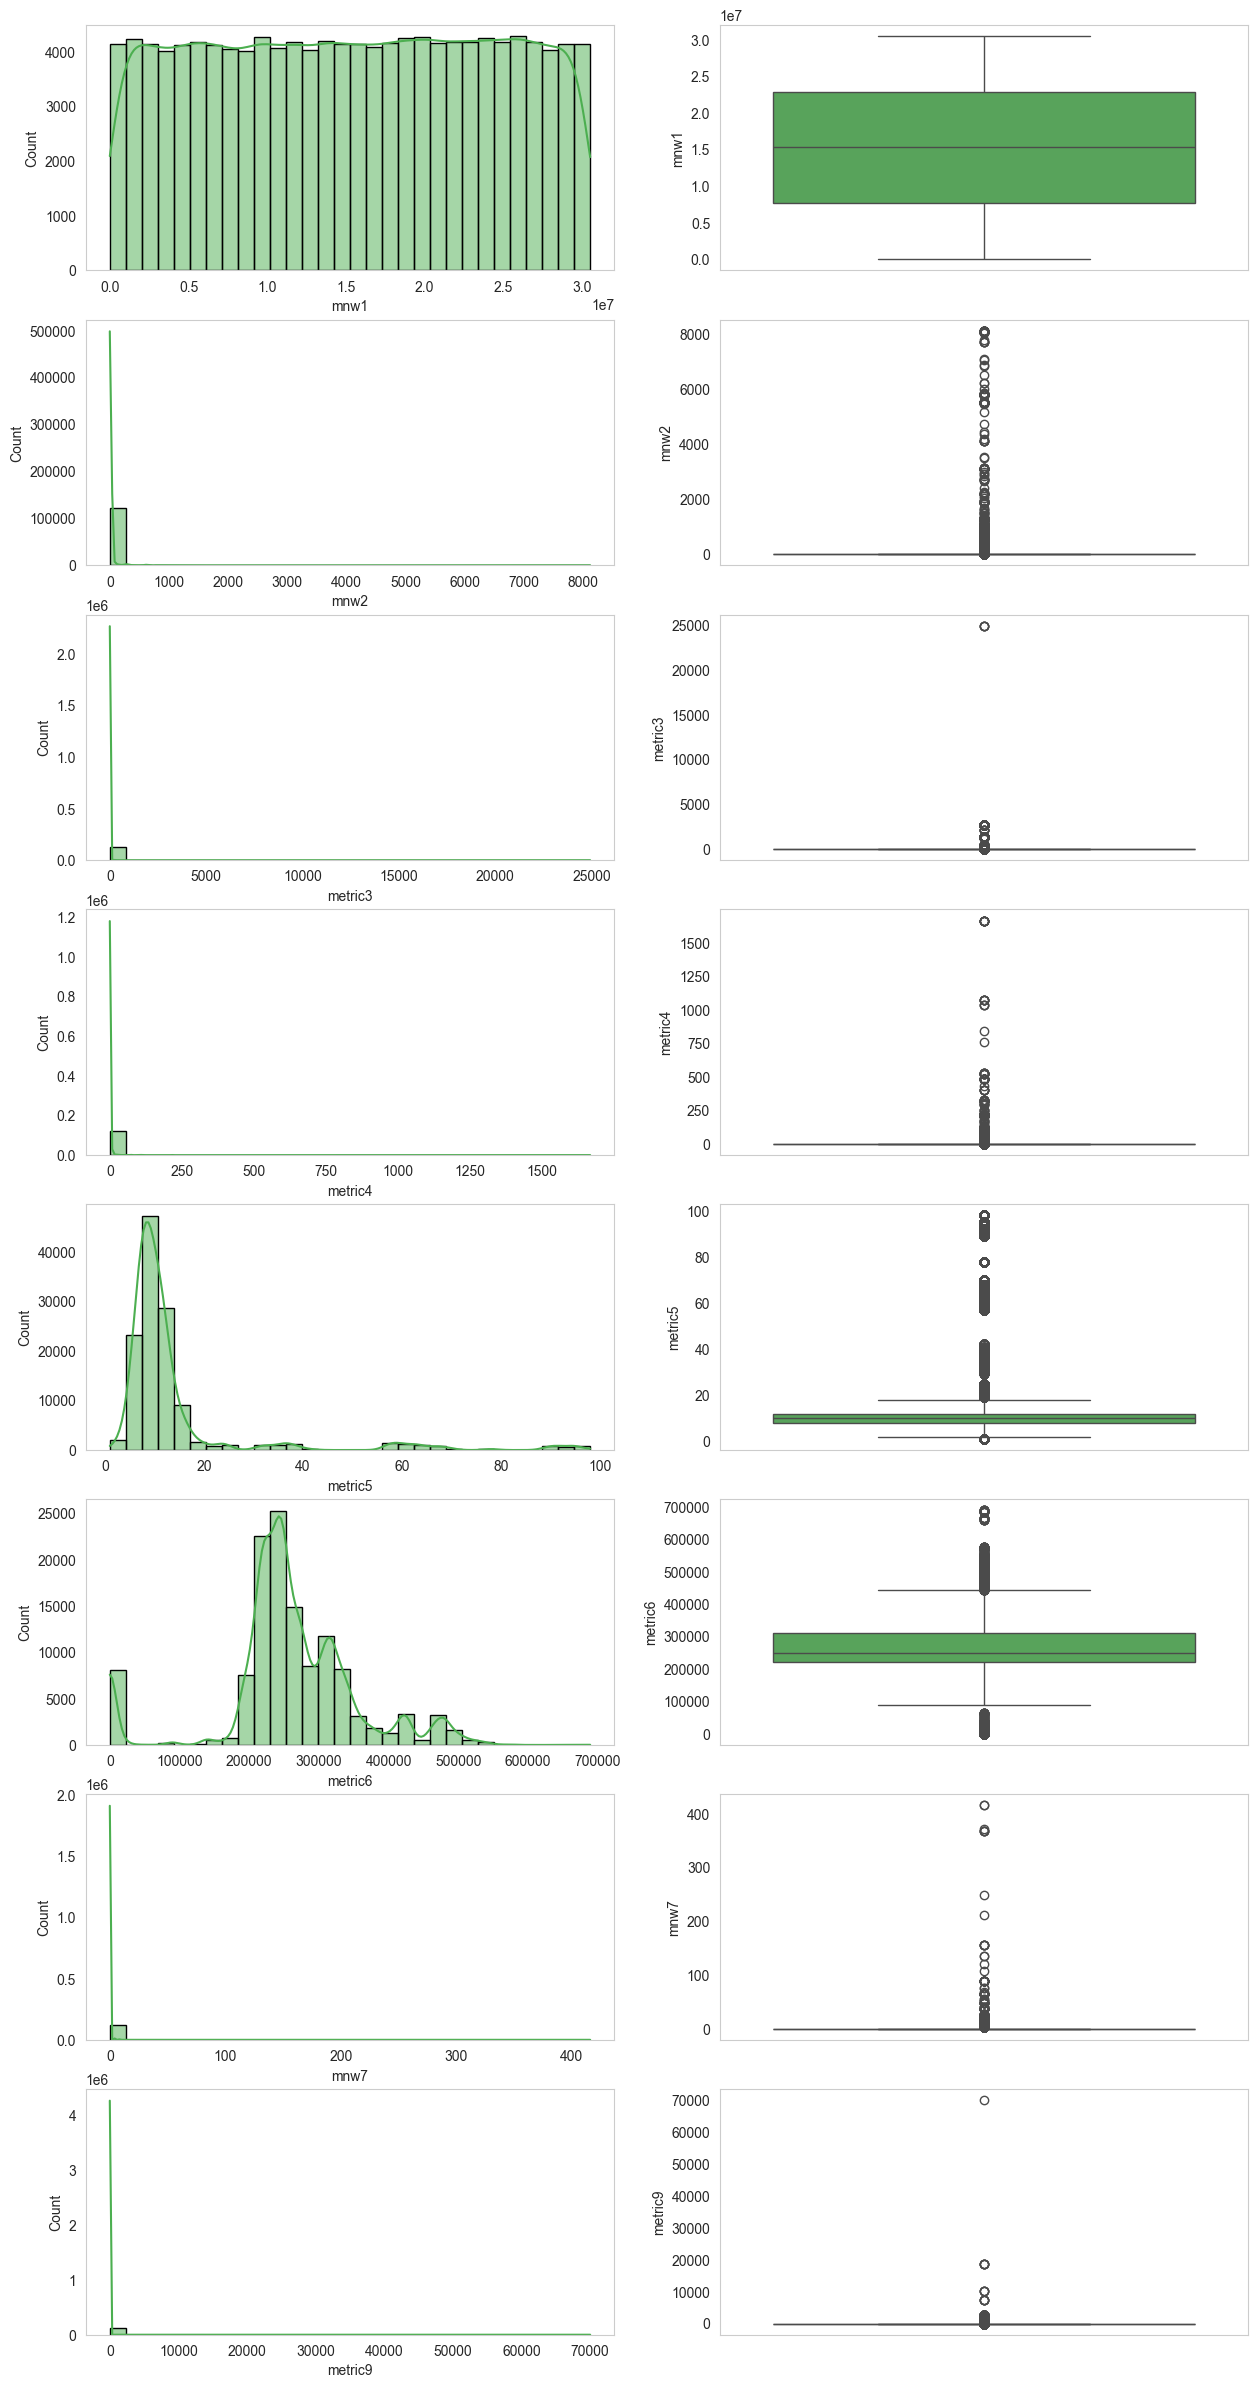

In [164]:
metrics = ['mnw1','mnw2','metric3', 'metric4', 'metric5', 'metric6', 'mnw7','metric9']
sns.set_style("whitegrid", {'axes.grid' : False})
figs, axs = plt.subplots(nrows = len(metrics),ncols = 2,figsize=(15,30))
for i in range(0,len(metrics)):
    sns.histplot(data = df_devices, x = metrics[i], bins = 30, ax = axs[i,0], kde=True, color='#4CAF50', edgecolor='black')
    sns.boxplot(data = df_devices, y = metrics[i], ax = axs[i,1], color='#4CAF50')

After observations, the following adjustments will be made:
- Considering the diverse concentrations in 'metric5' and 'metric6', they can act as continuous measurements of equipment characteristics. Hence, an auxiliary variable will be generated, representing the difference between the initial metric value and its subsequent values over the analyzed device's days.
- Due to the high skewness in 'mnw2', 'metric3', 'metric4', 'mnw7' and 'metric9', new variables will be created by taking their logarithmic format.

In [165]:
df_devices['dif_m6'] = df_devices['metric6']
df_devices['dif_m5'] = df_devices['metric5']

df_devices['log_m2'] = np.log(df_devices['mnw2']+1)
df_devices['log_m3'] = np.log(df_devices['metric3']+1)
df_devices['log_m4'] = np.log(df_devices['metric4']+1)
df_devices['log_m7'] = np.log(df_devices['mnw7']+1)
df_devices['log_m9'] = np.log(df_devices['metric9']+1)

df_devices.drop(['mnw2','metric3','metric4','mnw7','metric9'], axis = 1, inplace = True)
dev_name = df_devices['device'].unique()

for i in dev_name:
    filt = df_devices[df_devices['device'] == i]
    df.loc[filt.index,'dif_m6'] = filt['dif_m6'] - filt['metric6'].min()
    df.loc[filt.index,'dif_m5'] = filt['dif_m5'] - filt['metric5'].min()

In [166]:
df_devices.columns

Index(['date', 'device', 'failure', 'metric5', 'metric6', 'day', 'month',
       'year', 'day_of_week', 'week_of_month', 'sector', 'equipment',
       'op_period', 'dev_reconnected', 'mnw1', 'dif_m6', 'dif_m5', 'log_m2',
       'log_m3', 'log_m4', 'log_m7', 'log_m9'],
      dtype='object')

Distribution for failure is 0



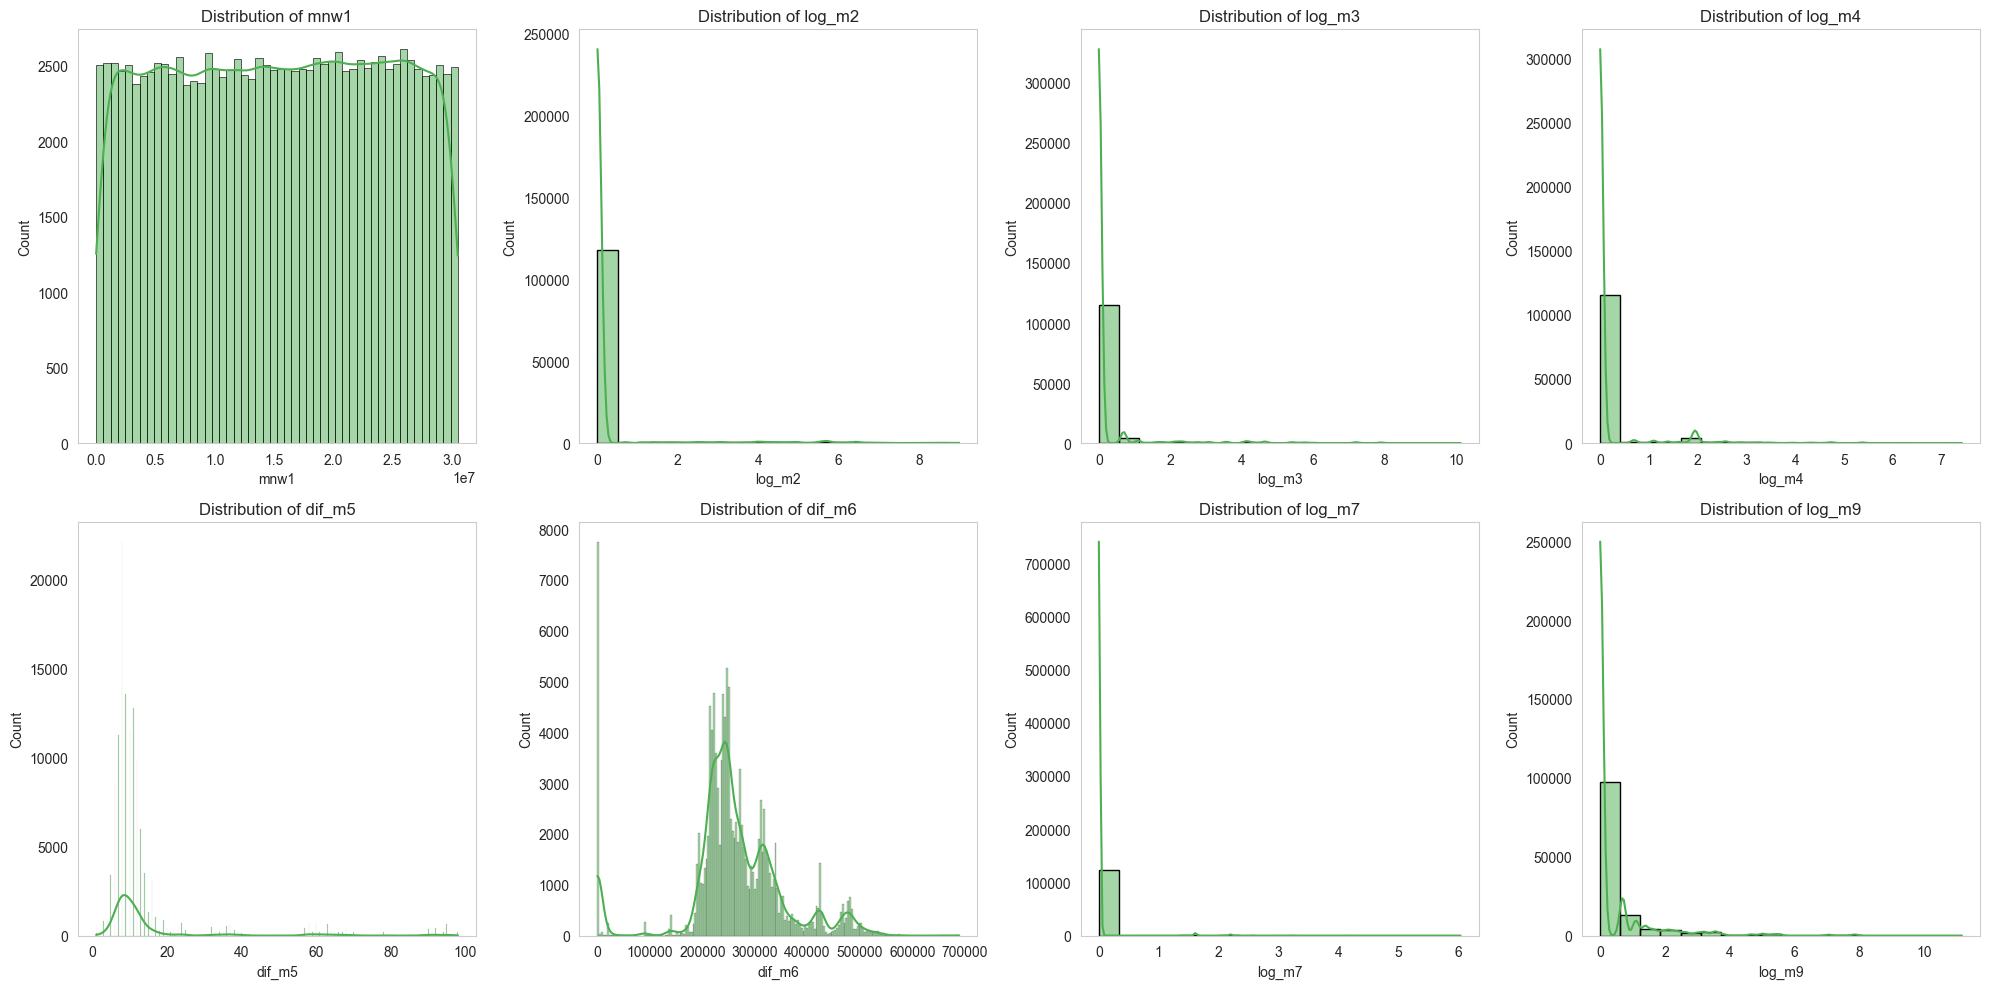

In [167]:
plt.figure(figsize=(4*5, 2*5))
sns.set_style("whitegrid", {'axes.grid' : False})
print("Distribution for failure is 0")
print()
mask= df_devices.failure==0
for i, col in enumerate(['mnw1', 'log_m2', 'log_m3', 'log_m4', 'dif_m5', 'dif_m6', 'log_m7', 'log_m9']):
    plt.subplot(2, 4, i + 1)
    sns.histplot(data=df_devices.loc[mask], x=col, kde=True, color='#4CAF50', edgecolor='black')
    plt.title(f'Distribution of {col}')

plt.tight_layout()

Distribution for failure is 1



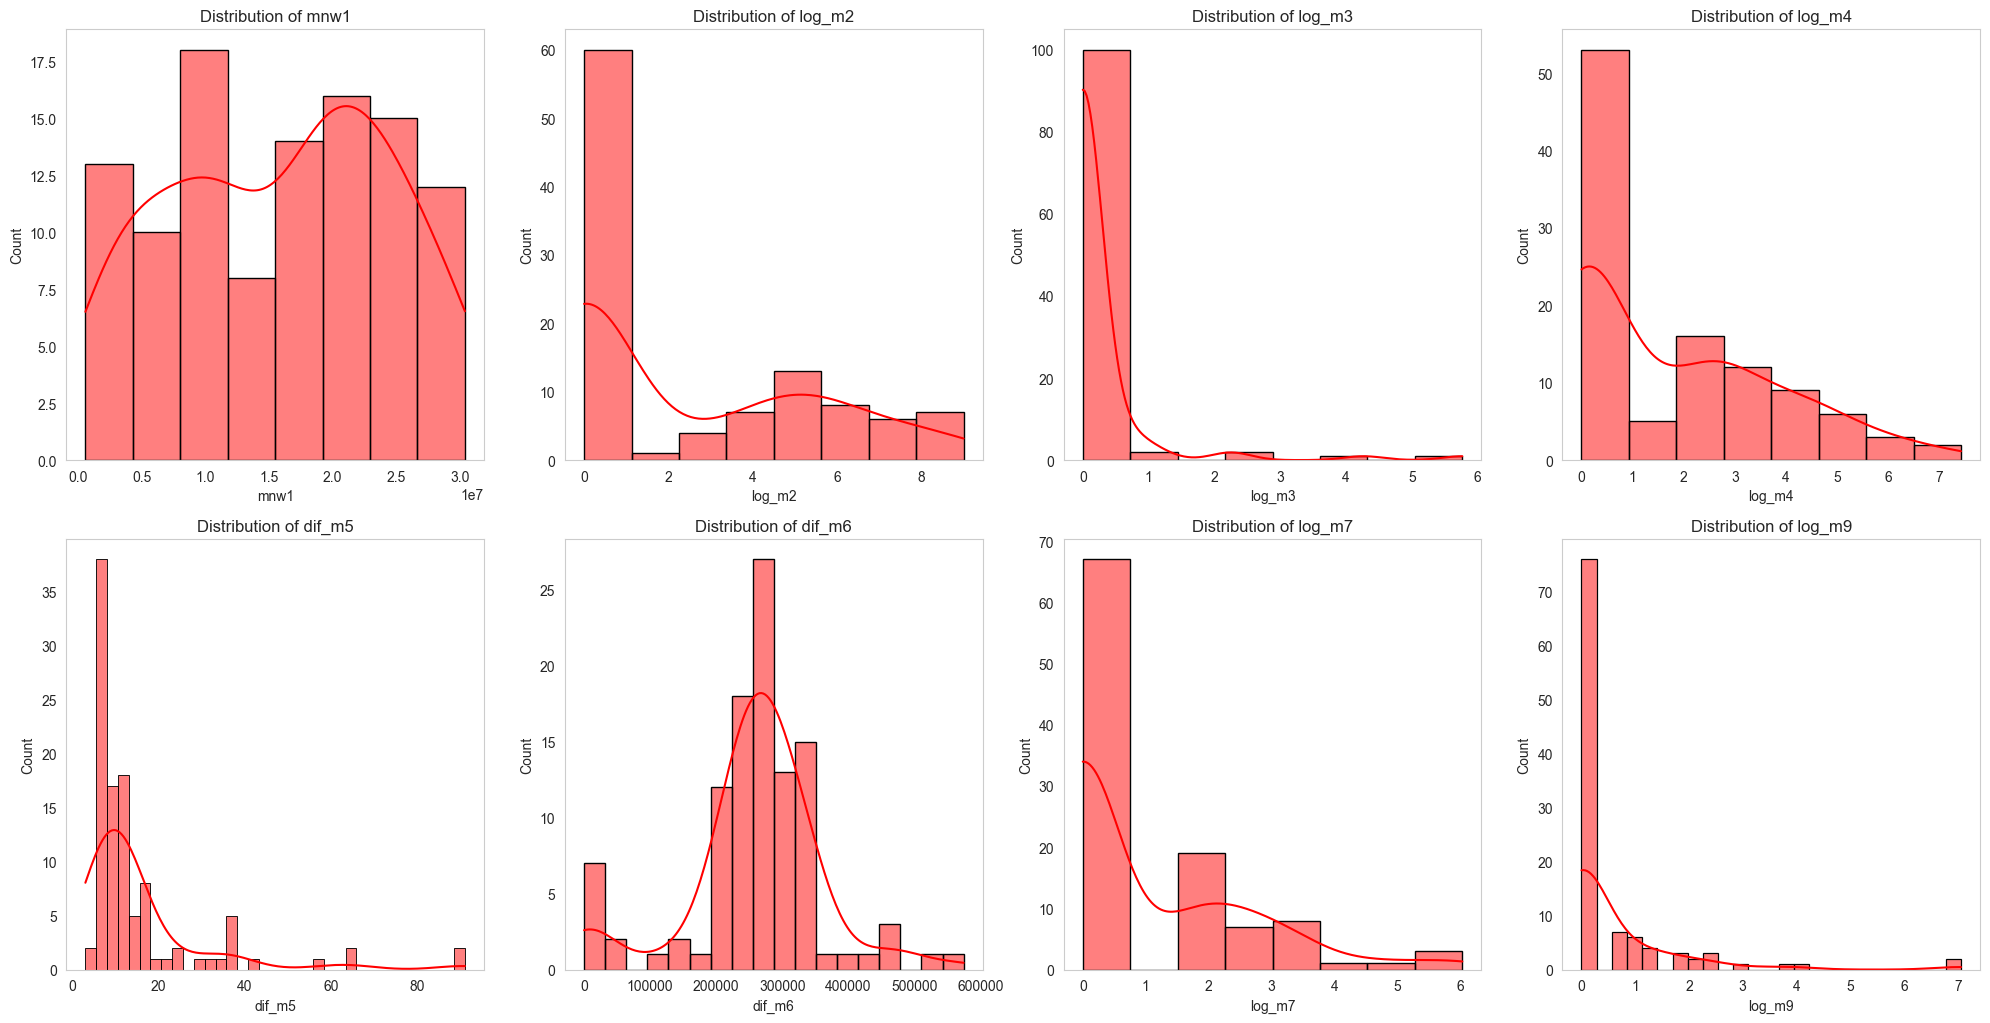

In [168]:
plt.figure(figsize=(4*5, 3*5))
sns.set_style("whitegrid", {'axes.grid' : False})
print("Distribution for failure is 1")
print()
mask= df_devices.failure==1
for i, col in enumerate(['mnw1', 'log_m2', 'log_m3', 'log_m4', 'dif_m5', 'dif_m6', 'log_m7', 'log_m9']):
    plt.subplot(3, 4, i + 1)
    sns.histplot(data=df_devices.loc[mask], x=col, kde=True, color='#ff0000', edgecolor='black')
    plt.title(f'Distribution of {col}')

plt.tight_layout()

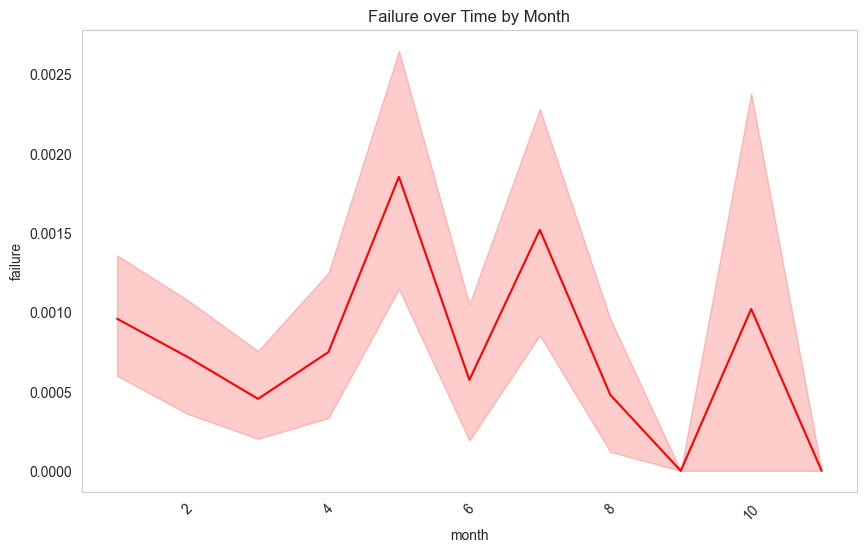

In [169]:
# Create a line plot to visualize 'failure' over time by month
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_devices, x='month', y='failure', color='#ff0000')
plt.xticks(rotation=45)
plt.title("Failure over Time by Month")
plt.show()

#### Observation
The number of failures are the most in Mai, Juni and Octobr

Text(0.5, 1.0, 'Failure over Time by day of Week')

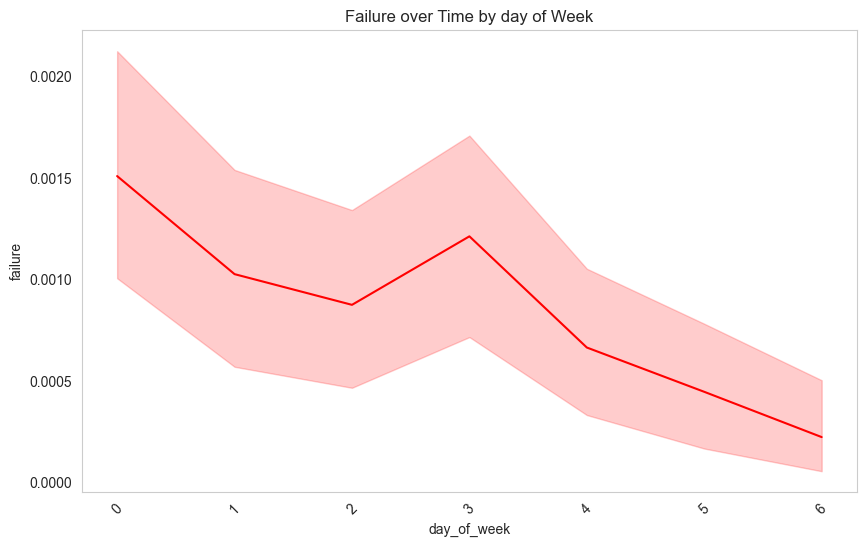

In [170]:
# Create a line plot to visualize 'failure' over time by day of week
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_devices, x='day_of_week', y='failure', color='#ff0000')
plt.xticks(rotation=45)
plt.title("Failure over Time by day of Week")

#### Observation

The number of failures are the most in first and forth days of weeks.

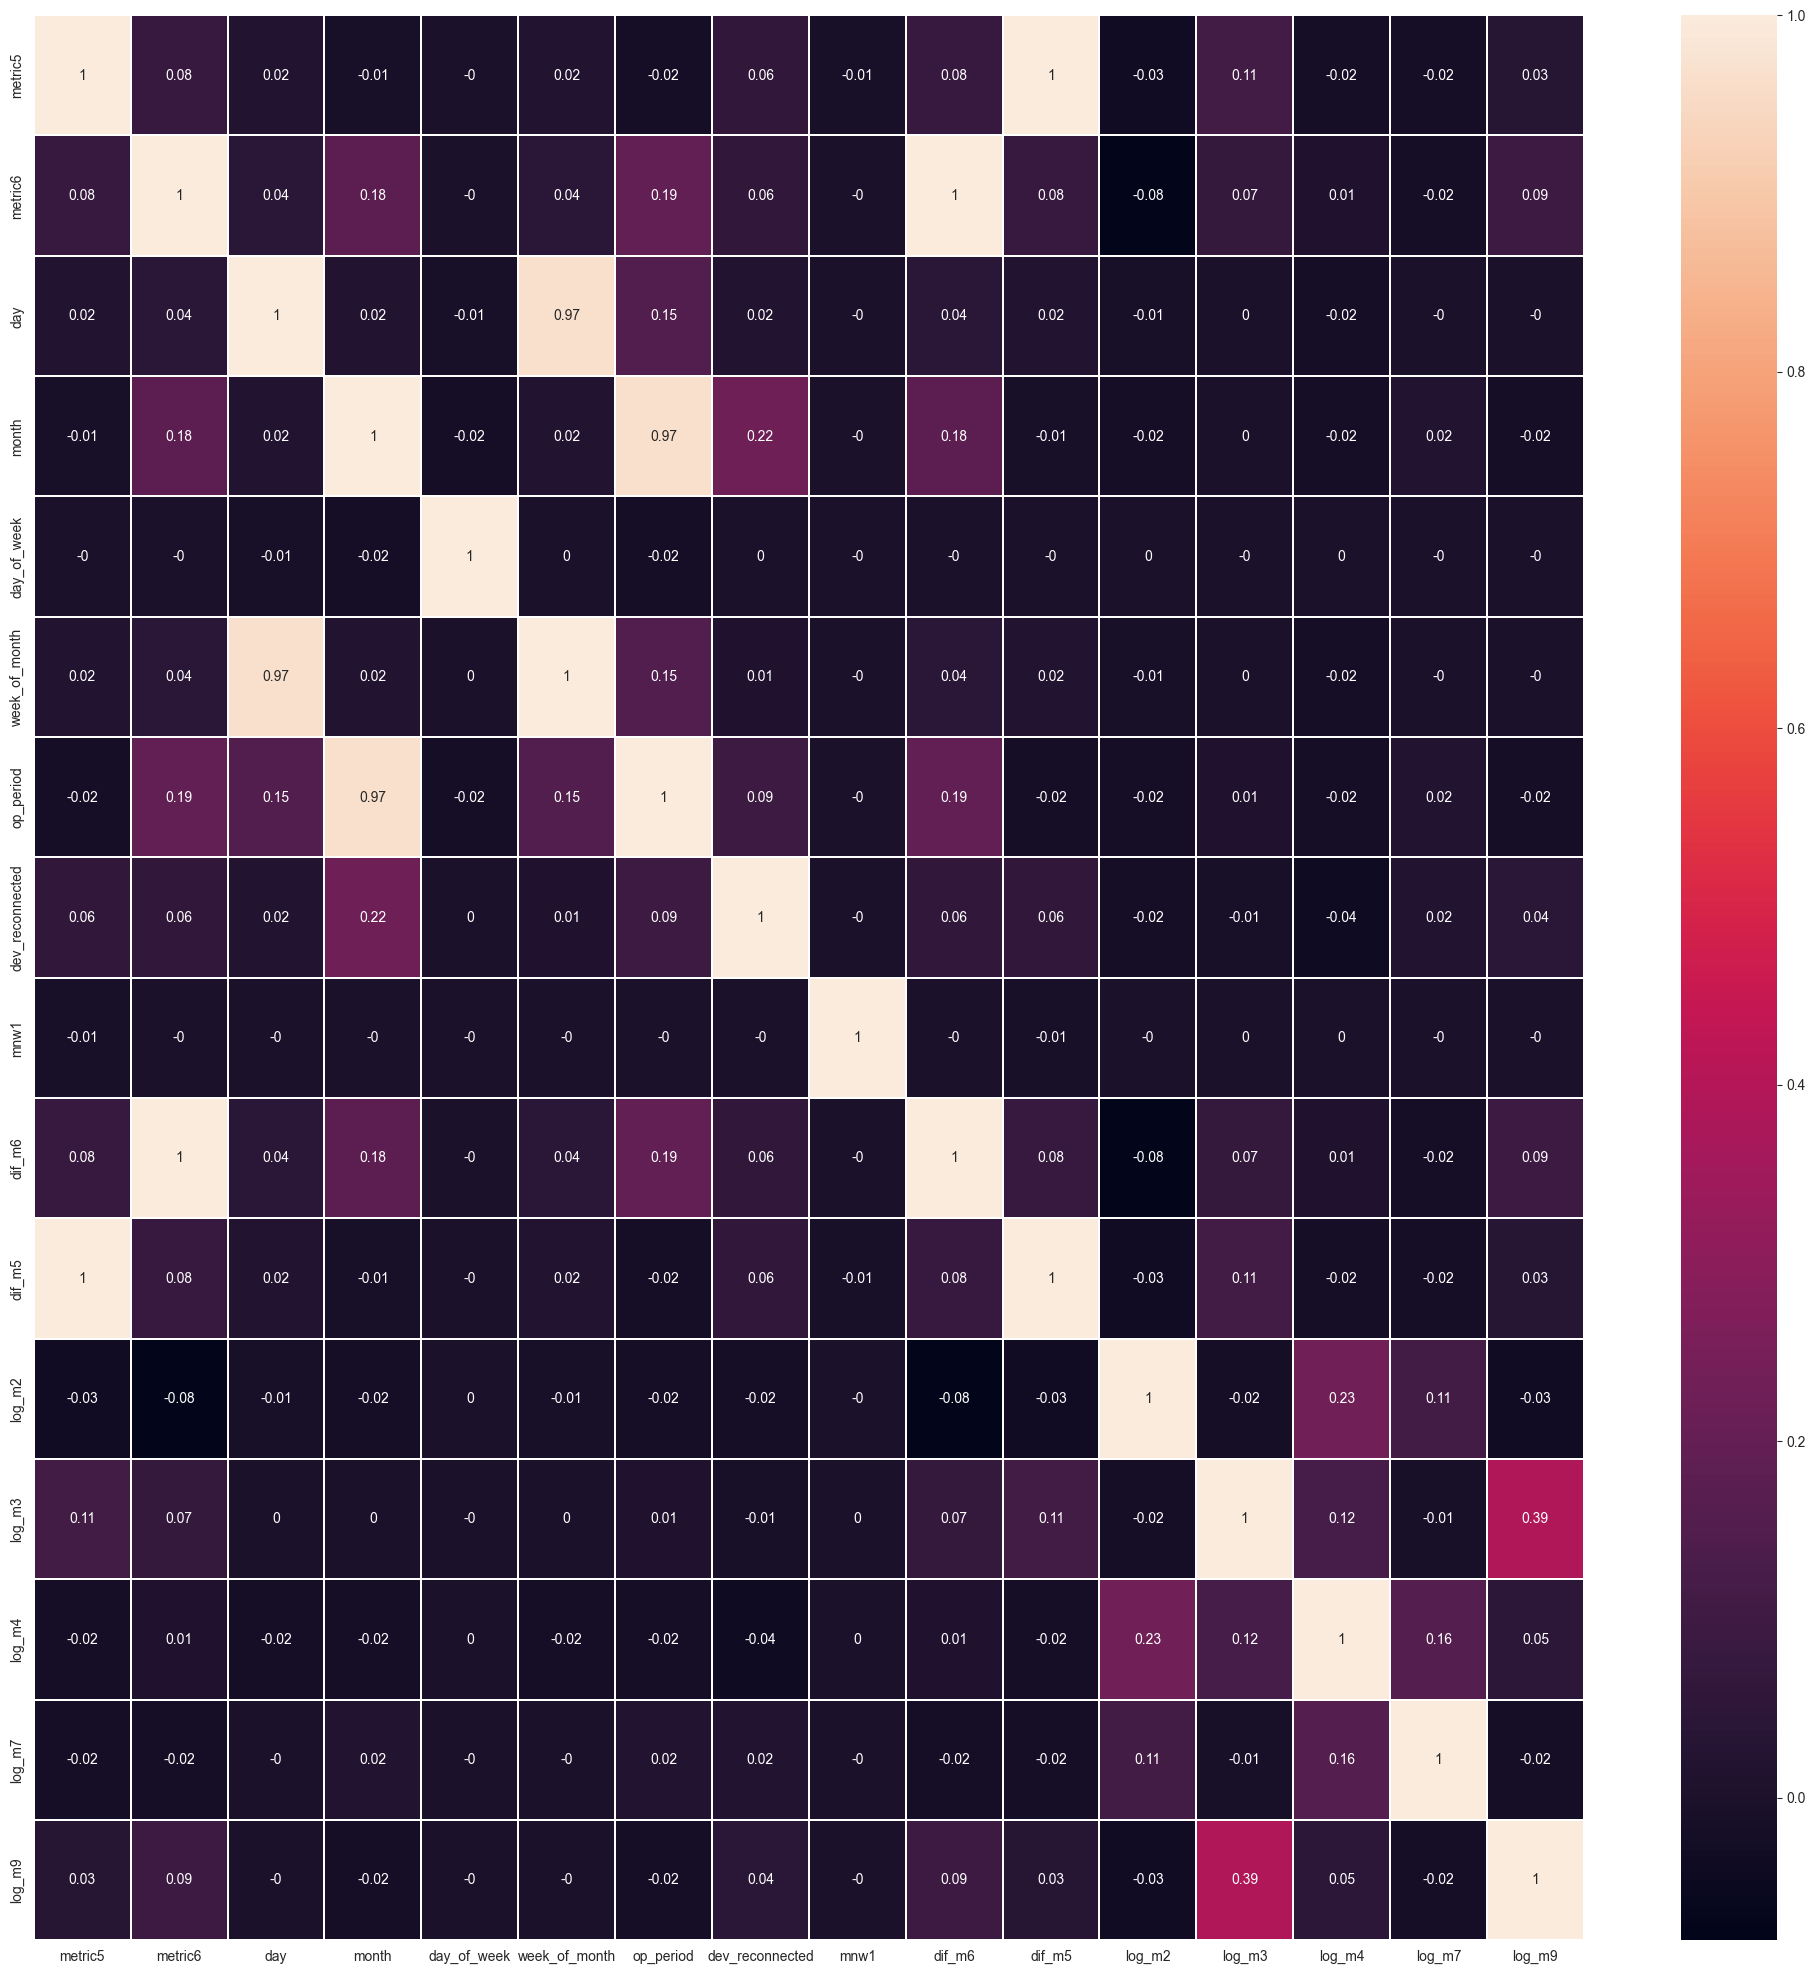

In [171]:
# Correlation
df_cod = df_devices.drop(['failure','equipment','device','date','year', 'sector'],axis =1)

fig, axes = plt.subplots(1, figsize=(25,25))
kendall_matrix = np.round(df_cod.corr(method='spearman'),2)
fig = sns.heatmap(kendall_matrix, annot=True,linewidths=.1)

It seems that there is no significant correlation between features and target.

Due to certain correlations and redundancies observed:
- Since 'week_of_month' demonstrates a high correlation with 'day', 'week_of_month' will be removed.
- Due to a notable correlation between 'month' and 'op_period', 'month' will be removed.
- Considering that all data was collected in the same year, the 'year' feature will be removed.
- The 'device' feature, now separated into 'sector' and 'equipment', will be eliminated.
- Recognizing that 'equipment' serves as a unique ID and might overly influence the model in certain cases, it will be removed.

In [172]:
df_devices_final = df_devices.drop(['device','year','equipment','date', 'op_period', 'dev_reconnected'],axis =1)

In [173]:
df_devices_final.columns

Index(['failure', 'metric5', 'metric6', 'day', 'month', 'day_of_week',
       'week_of_month', 'sector', 'mnw1', 'dif_m6', 'dif_m5', 'log_m2',
       'log_m3', 'log_m4', 'log_m7', 'log_m9'],
      dtype='object')

## ML

In [174]:
df_devices_final=pd.get_dummies(df_devices_final,drop_first=True)

Performing random under-sampling before training a machine learning model can be beneficial, especially when dealing with imbalanced datasets.
Imbalanced Datasets:
Based on our observations our dataset is imbalanced, meaning that one class (e.g., failures) is significantly underrepresented compared to another class (e.g., non-failures). Imbalanced datasets can lead to biased models that perform poorly on the minority class.
Random Under-Sampling:
Random under-sampling aims to balance the class distribution by randomly removing instances from the majority class (non-failures in this case) until a more balanced representation is achieved. This helps prevent the model from being dominated by the majority class and improves its ability to learn patterns from the minority class.

In [175]:
# Create a copy of the DataFrame
X = df_devices_final.copy()

# Create the target variable 'Y' by selecting the 'failure' column
Y = df_devices_final["failure"]

# Remove the 'failure' column from the feature matrix 'X'
X.drop("failure", axis=1, inplace=True)

In [176]:
# Create an instance of the RandomUnderSampler with a fixed random state
rus = RandomUnderSampler(random_state=42)

# Perform random under-sampling and obtain resampled feature matrix and target variable
X_resampled, y_resampled = rus.fit_resample(X, Y)

In [177]:
# Create a new DataFrame 'under_sample' by copying the resampled features and adding the 'failure' column back
under_sample = X_resampled.copy()
under_sample["failure"] = y_resampled

In [178]:
# Display a random sample of 10 rows from the under-sampled dataset
under_sample.sample(10)

,metric5,metric6,day,month,day_of_week,week_of_month,mnw1,dif_m6,dif_m5,log_m2,...,log_m4,log_m7,log_m9,sector_S1F1,sector_W1F0,sector_W1F1,sector_Z1F0,sector_Z1F1,sector_Z1F2,failure
49707,24,48,8,3,6,2,11325207,48,24,5.53,...,0.00,0.00,0.00,False,False,True,False,False,False,0
24595,11,217531,31,1,5,5,26634933,217531,11,0.00,...,0.00,0.00,1.39,True,False,False,False,False,False,0
84068,6,258189,21,5,3,3,17717748,258189,6,0.00,...,0.00,0.00,0.00,False,False,True,False,False,False,0
22353,12,263908,28,1,2,4,28668149,263908,12,0.00,...,0.00,0.00,0.00,False,False,False,False,False,False,0
77759,78,245348,4,5,0,1,10530390,245348,78,0.00,...,0.00,0.00,4.65,False,False,False,True,False,False,0
77958,16,343464,5,5,1,1,16439976,343464,16,0.00,...,3.26,1.61,0.00,True,False,False,False,False,False,1
22506,64,200990,28,1,2,4,28675089,200990,64,0.00,...,3.69,1.61,1.10,False,True,False,False,False,False,1
3509,14,321995,4,1,6,1,12062216,321995,14,0.00,...,3.18,0.00,2.20,False,False,False,False,False,False,0
19059,7,245849,23,1,4,4,8051021,245849,7,0.00,...,0.00,3.22,0.00,False,True,False,False,False,False,1
16223,12,233238,19,1,0,3,9734699,233238,12,0.00,...,0.00,0.00,0.00,False,True,False,False,False,False,1


In [179]:
# Create feature matrix 'X_norm' and target variable 'y_norm'
X_norm = under_sample.drop(['failure'], axis=1)
y_norm = under_sample['failure']

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X_norm, y_norm, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [180]:
# Define a function to evaluate multiple classifiers and return a DataFrame with metrics
def evaluate_model(x_train, y_train, x_test, y_test):
    # Define a list of classifiers
    classifiers = [
        GradientBoostingClassifier(),
        RandomForestClassifier(),
        AdaBoostClassifier(),
        ExtraTreesClassifier(),
        DecisionTreeClassifier(),
        KNeighborsClassifier(),
        GaussianNB(),
        BernoulliNB(),
        SVC(),
        LogisticRegression(),
        SGDClassifier(),
    ]
    # Define the names of classifiers
    classifier_names = [
        'GradientBoost',
        'RandomForest',
        'AdaBoost',
        'ExtraTrees',
        'DecisionTree',
        'KNeighbors',
        'GaussianNB',
        'BernoulliNB',
        'SVC',
        'LogisticRegression',
        'SGD',
    ]

    # Create an empty DataFrame for metrics
    metrics = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1'], index=classifier_names)
    # Evaluate each classifier and store the metrics
    for i, clf in enumerate(classifiers):
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        metrics.loc[classifier_names[i], 'Accuracy'] = accuracy
        metrics.loc[classifier_names[i], 'Precision'] = precision
        metrics.loc[classifier_names[i], 'Recall'] = recall
        metrics.loc[classifier_names[i], 'F1'] = f1

    # Sort the metrics by accuracy in descending order
    metrics = metrics.sort_values(by='Accuracy', ascending=False)

    return metrics

# Step 4: Evaluate models
metrics = evaluate_model(x_train, y_train, x_test, y_test)

In [181]:
metrics

,Accuracy,Precision,Recall,F1
GradientBoost,0.81,0.83,0.83,0.83
RandomForest,0.79,0.83,0.79,0.81
DecisionTree,0.79,0.83,0.79,0.81
BernoulliNB,0.79,0.89,0.71,0.79
AdaBoost,0.74,0.81,0.71,0.76
SVC,0.74,0.84,0.67,0.74
ExtraTrees,0.72,0.73,0.79,0.76
LogisticRegression,0.70,0.82,0.58,0.68
SGD,0.67,0.73,0.67,0.70
GaussianNB,0.65,0.76,0.54,0.63


### GradientBoosting

In [182]:
def objective_gb(trial):
    # Define hyperparameters to optimize
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),
    }

    # Initialize the classifier with hyperparameters
    clf = GradientBoostingClassifier(**params, random_state=42)

    # Train the classifier on the training data
    clf.fit(x_train, y_train)
    
    # Make predictions on the test data
    y_pred = clf.predict(x_test)

    # Calculate F1 score as the objective to maximize
    f1 = f1_score(y_test, y_pred)

    return f1

In [183]:
def create_study(objective):
    # Create an Optuna study

    # Set logging level to WARNING to suppress unnecessary output
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study = optuna.create_study(direction='maximize')  # We want to maximize accuracy

    # Run the optimization
    study.optimize(objective, n_trials=100)  # You can adjust the number of trials

    # Get the best hyperparameters from the study
    best_params = study.best_params
    best_f1 = study.best_value
    print(f'Best hyperparameters: {best_params}')
    print(f'Best f1 score: {best_f1}')
    return best_params

In [184]:
best_params=create_study(objective_gb)
best_gb = GradientBoostingClassifier(**best_params, random_state=42)
y_pred_gb=best_gb.fit(x_train, y_train).predict(x_test)

Best hyperparameters: {'n_estimators': 91, 'learning_rate': 0.06207510810080687, 'max_depth': 7, 'min_samples_split': 0.10279392785928225}
Best f1 score: 0.8936170212765957


### RandomForest

In [185]:
def objective_rf(trial):
    # Define the hyperparameters to optimize
    n_estimators = trial.suggest_int('n_estimators', 10, 150)
    max_depth = trial.suggest_int('max_depth', 2, 32)
    min_samples_split = trial.suggest_uniform('min_samples_split', 0.1, 1.0)
    min_samples_leaf = trial.suggest_uniform('min_samples_leaf', 0.1, 0.5)
    max_features = trial.suggest_categorical('max_features', ['log2', 'sqrt'])  # Only suggest valid options
    
    # Create and train the RandomForestClassifier with the suggested hyperparameters
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )
    
    # Train the classifier on the training data
    clf.fit(x_train, y_train)
    
    # Make predictions on the test data
    y_pred = clf.predict(x_test)

    # Calculate F1 score as the objective to maximize
    f1 = f1_score(y_test, y_pred)

    return f1

In [186]:
best_params=create_study(objective_rf)
best_rf = RandomForestClassifier(**best_params, random_state=42)
y_pred_rf=best_rf.fit(x_train, y_train).predict(x_test)

Best hyperparameters: {'n_estimators': 19, 'max_depth': 27, 'min_samples_split': 0.18512769948610233, 'min_samples_leaf': 0.10884827910362688, 'max_features': 'log2'}
Best f1 score: 0.8444444444444444


### AdaBoost

In [187]:
# Define the objective function for Optuna
def objective_ab(trial):
    # Define the hyperparameters to optimize
    n_estimators = trial.suggest_int("n_estimators", 50, 200)  # Number of weak learners
    learning_rate = trial.suggest_float("learning_rate", 0.01, 1.0)  # Learning rate
    algorithm = trial.suggest_categorical("algorithm", ["SAMME", "SAMME.R"])  # AdaBoost algorithm

    # Create an AdaBoostClassifier with the suggested hyperparameters
    model = AdaBoostClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        algorithm=algorithm,
        random_state=42
    )

    # Train the model
    model.fit(x_train, y_train)

    # Make predictions on the validation set
    y_pred = model.predict(x_test)

    # Calculate F1 score as the objective to maximize
    f1 = f1_score(y_test, y_pred)

    return f1

In [188]:
best_params=create_study(objective_ab)
best_ab = AdaBoostClassifier(**best_params, random_state=42)
y_pred_ab=best_ab.fit(x_train, y_train).predict(x_test)

Best hyperparameters: {'n_estimators': 110, 'learning_rate': 0.5485299354085771, 'algorithm': 'SAMME.R'}
Best f1 score: 0.8085106382978724


### ExtraTrees

In [189]:
def objective_etc(trial):
    # Define the hyperparameters to optimize
    n_estimators = trial.suggest_int("n_estimators", 100, 1000)
    max_depth = trial.suggest_int("max_depth", 1, 32)
    min_samples_split = trial.suggest_float("min_samples_split", 0.1, 1.0)
    min_samples_leaf = trial.suggest_float("min_samples_leaf", 0.1, 0.5)

    # Create an ExtraTrees classifier with the suggested hyperparameters
    clf = ExtraTreesClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42  # You can set a random seed for reproducibility
    )

    # Fit the classifier on the training data
    clf.fit(x_train, y_train)

    # Make predictions on the test data
    y_pred = clf.predict(x_test)

    # Calculate F1 score as the objective to maximize
    f1 = f1_score(y_test, y_pred)

    return f1

In [190]:
best_params=create_study(objective_etc)
best_etc = ExtraTreesClassifier(**best_params, random_state=42)
y_pred_etc=best_etc.fit(x_train, y_train).predict(x_test)

Best hyperparameters: {'n_estimators': 158, 'max_depth': 3, 'min_samples_split': 0.40337679562285633, 'min_samples_leaf': 0.10329124057665606}
Best f1 score: 0.761904761904762


### Decision Tree

In [191]:
# Define the objective function to optimize
def objective_dt(trial):
    # Define hyperparameters to search and their respective ranges
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
    min_samples_split = trial.suggest_uniform('min_samples_split', 0.1, 1.0)
    min_samples_leaf = trial.suggest_uniform('min_samples_leaf', 0.1, 0.5)

    # Create a DecisionTree classifier with the suggested hyperparameters
    clf = DecisionTreeClassifier(
        criterion=criterion,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42  # Set a random state for reproducibility
    )

    # Fit the classifier on the training data
    clf.fit(x_train, y_train)

    # Make predictions on the test data
    y_pred = clf.predict(x_test)

    # Calculate F1 score as the objective to maximize
    f1 = f1_score(y_test, y_pred)

    return f1

In [192]:
best_params=create_study(objective_dt)
best_dt = DecisionTreeClassifier(**best_params, random_state=42)
y_pred_dt=best_dt.fit(x_train, y_train).predict(x_test)

Best hyperparameters: {'criterion': 'entropy', 'max_depth': 11, 'min_samples_split': 0.13364444784673674, 'min_samples_leaf': 0.10288711617450583}
Best f1 score: 0.6818181818181818


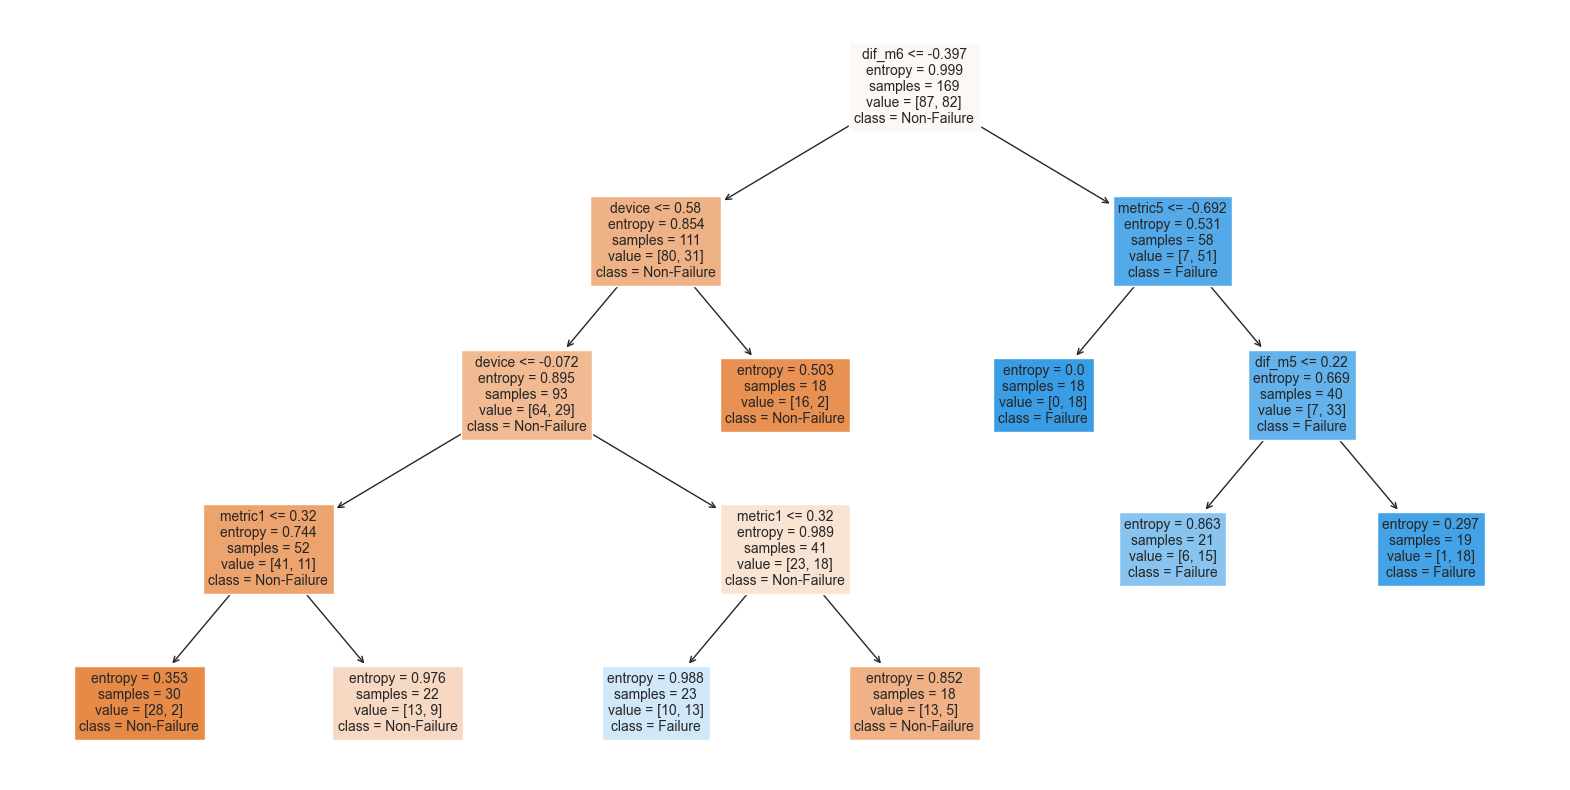

In [193]:
# Plot the Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(best_dt, feature_names=df.drop("failure",axis=1).columns.to_list(), class_names=["Non-Failure", "Failure"], filled=True, fontsize=10)
plt.show()

### KNN

In [194]:
def objective_knn(trial):
    # Define hyperparameters to optimize
    params = {
        'n_neighbors': trial.suggest_int('n_neighbors', 3, 20),
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
        'p': trial.suggest_int('p', 1, 2),  # p=1 for Manhattan distance, p=2 for Euclidean distance
    }

    # Initialize the classifier with hyperparameters
    clf = KNeighborsClassifier(**params)

    # Train the classifier on the training data
    clf.fit(x_train, y_train)
    
    # Make predictions on the test data
    y_pred = clf.predict(x_test)    

    # Calculate F1 score as the objective to maximize
    f1 = f1_score(y_test, y_pred)

    return f1

In [195]:
best_params=create_study(objective_knn)
best_knn = KNeighborsClassifier(**best_params)
y_pred_knn=best_knn.fit(x_train, y_train).predict(x_test)

Best hyperparameters: {'n_neighbors': 3, 'weights': 'uniform', 'p': 2}
Best f1 score: 0.6222222222222222


### GaussianNB

In [196]:
best_gnb = GaussianNB()
y_pred_gnb=best_gnb.fit(x_train, y_train).predict(x_test)

### BernoulliNB

In [197]:
def objective_bnb(trial):
    # Define hyperparameters to optimize
    params = {
        'alpha': trial.suggest_loguniform('alpha', 1e-10, 1.0),
        'binarize': trial.suggest_float('binarize', 0.0, 1.0),
        'fit_prior': trial.suggest_categorical('fit_prior', [True, False]),
    }

    # Initialize the classifier with hyperparameters
    clf = BernoulliNB(**params)

    # Train the classifier on the training data
    clf.fit(x_train, y_train)
    
    # Make predictions on the test data
    y_pred = clf.predict(x_test)
    

    # Calculate F1 score as the objective to maximize
    f1 = f1_score(y_test, y_pred)

    return f1

In [198]:
best_params=create_study(objective_bnb)
best_bnb = BernoulliNB(**best_params)
y_pred_bnb=best_bnb.fit(x_train, y_train).predict(x_test)

Best hyperparameters: {'alpha': 0.00023538357513501219, 'binarize': 0.39072708454003124, 'fit_prior': True}
Best f1 score: 0.7906976744186046


### SVC

In [199]:
def objective_svc(trial):
    # Define hyperparameters to optimize
    params = {
        'C': trial.suggest_loguniform('C', 1e-3, 1e3),
        'kernel': trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
        'degree': trial.suggest_int('degree', 2, 5) if trial.params['kernel'] == 'poly' else 1,
        'gamma': trial.suggest_categorical('gamma', ['scale', 'auto']) if trial.params['kernel'] in ['rbf', 'poly', 'sigmoid'] else 'scale',
    }

    # Initialize the classifier with hyperparameters
    clf = SVC(**params, random_state=42)

    # Train the classifier on the training data
    clf.fit(x_train, y_train)
    
    # Make predictions on the test data
    y_pred = clf.predict(x_test)
    
    # Calculate F1 score as the objective to maximize
    f1 = f1_score(y_test, y_pred)

    return f1

In [200]:
best_params=create_study(objective_svc)
best_svc = SVC(**best_params)
y_pred_svc=best_svc.fit(x_train, y_train).predict(x_test)

Best hyperparameters: {'C': 0.19591963738009072, 'kernel': 'linear'}
Best f1 score: 0.761904761904762


### LogisticRegression

In [201]:
def objective_lr(trial):
    # Define hyperparameters to optimize
    params = {
        'C': trial.suggest_loguniform('C', 1e-5, 1e5),
        'solver': trial.suggest_categorical('solver', ['liblinear', 'lbfgs']),
    }

    # Initialize the classifier with hyperparameters
    clf = LogisticRegression(**params, random_state=42)

    # Train the classifier on the training data
    clf.fit(x_train, y_train)
    
    # Make predictions on the test data
    y_pred = clf.predict(x_test)
    
    # Calculate F1 score as the objective to maximize
    f1 = f1_score(y_test, y_pred)

    return f1

In [202]:
best_params=create_study(objective_lr)
best_lr = LogisticRegression(**best_params)
y_pred_lr=best_lr.fit(x_train, y_train).predict(x_test)

Best hyperparameters: {'C': 480.29248851767824, 'solver': 'liblinear'}
Best f1 score: 0.6829268292682927


## Comparing Models


Model: Model Gradient Boosting
Precision: 0.9130
Recall: 0.8750
F1 Score: 0.8936
Accuracy: 0.8837

Model: Model Random Forest
Precision: 0.9048
Recall: 0.7917
F1 Score: 0.8444
Accuracy: 0.8372

Model: Model AdaBoost
Precision: 0.8261
Recall: 0.7917
F1 Score: 0.8085
Accuracy: 0.7907

Model: Model Extra Tree
Precision: 0.8889
Recall: 0.6667
F1 Score: 0.7619
Accuracy: 0.7674

Model: Decison Tree
Precision: 0.7500
Recall: 0.6250
F1 Score: 0.6818
Accuracy: 0.6744

Model: KNN
Precision: 0.6667
Recall: 0.5833
F1 Score: 0.6222
Accuracy: 0.6047

Model: GaussianNB
Precision: 0.7647
Recall: 0.5417
F1 Score: 0.6341
Accuracy: 0.6512

Model: BernoulliNB
Precision: 0.8947
Recall: 0.7083
F1 Score: 0.7907
Accuracy: 0.7907

Model: SVC
Precision: 0.8889
Recall: 0.6667
F1 Score: 0.7619
Accuracy: 0.7674

Model: LogisticRegression
Precision: 0.8235
Recall: 0.5833
F1 Score: 0.6829
Accuracy: 0.6977


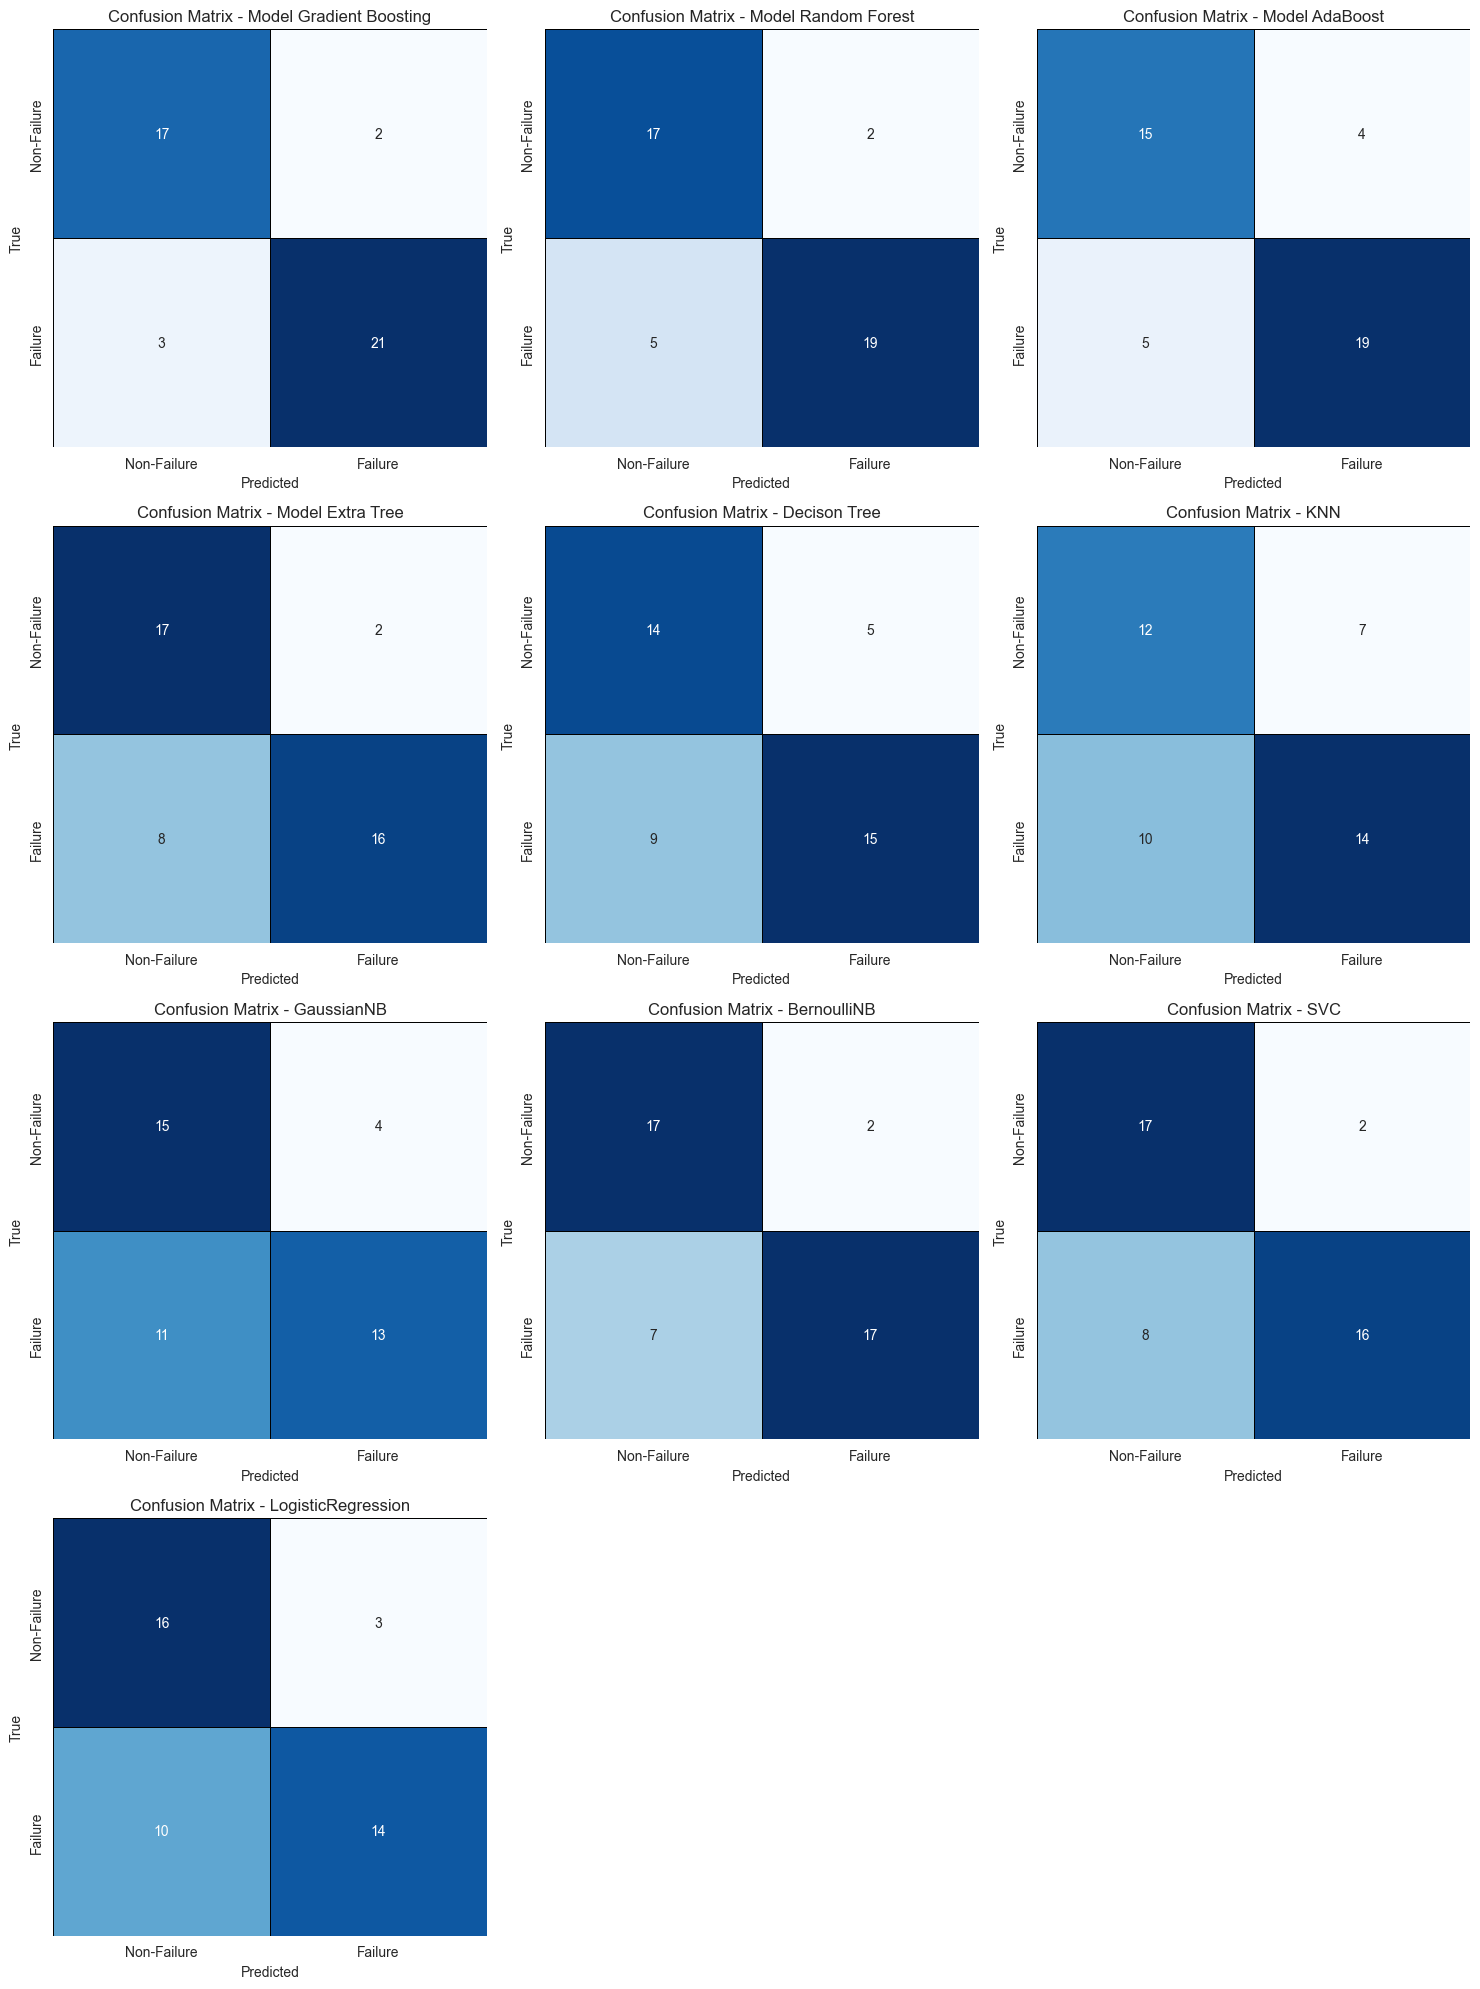


=====Best Model=====

Model: Model Gradient Boosting
Precision: 0.9130
Recall: 0.8750
F1 Score: 0.8936
Accuracy: 0.8837


In [203]:
# Function to calculate evaluation metrics
def calculate_evaluation_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    
    return precision, recall, f1, accuracy
def plot_confusion_matrix(ax, y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5, linecolor="black", cbar=False, xticklabels=["Non-Failure", "Failure"], yticklabels=["Non-Failure", "Failure"], ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(title)
# Initialize variables to store best metrics
best_model = ""
best_f1 = 0.0
best_precision = 0.0
best_recall = 0.0
best_accuracy = 0.0

# Create a 2x2 subplot grid
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(3*5, 4*5))

# Plot each confusion matrix and find the best model
models = [
    ("Model Gradient Boosting", y_pred_gb),
    ("Model Random Forest", y_pred_rf),
    ("Model AdaBoost", y_pred_ab),
    ("Model Extra Tree", y_pred_etc),
    ("Decison Tree", y_pred_dt),
    ("KNN", y_pred_knn),
    ("GaussianNB", y_pred_gnb),
    ("BernoulliNB",y_pred_bnb),
    ("SVC", y_pred_svc),
    ("LogisticRegression", y_pred_lr)
]

for (model_name, y_pred), ax in zip(models, axes.flatten()):
    plot_confusion_matrix(ax, y_test, y_pred, f"Confusion Matrix - {model_name}")
    
    # Calculate evaluation metrics
    precision, recall, f1, accuracy = calculate_evaluation_metrics(y_test, y_pred)
    
    # Print evaluation metrics
    print(f"\nModel: {model_name}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Accuracy: {accuracy:.4f}")

    # Update best model if current model has higher F1 score
    if f1 > best_f1:
        best_f1 = f1
        best_model = model_name
        best_precision = precision
        best_recall = recall
        best_accuracy = accuracy



# Adjust layout
plt.tight_layout()
# Remove the last two subplots
for i in range(2):
    fig.delaxes(axes.flatten()[-(i+1)])
plt.show()

# Print the best model
print("\n=====Best Model=====\n")
print(f"Model: {best_model}")
print(f"Precision: {best_precision:.4f}")
print(f"Recall: {best_recall:.4f}")
print(f"F1 Score: {best_f1:.4f}")
print(f"Accuracy: {best_accuracy:.4f}")

#### =====Best Model=====

Model: Model Gradient Boosting
Precision: 0.9130
Recall: 0.8750
F1 Score: 0.8936
Accuracy: 0.8837



AUC: 0.8848684210526315


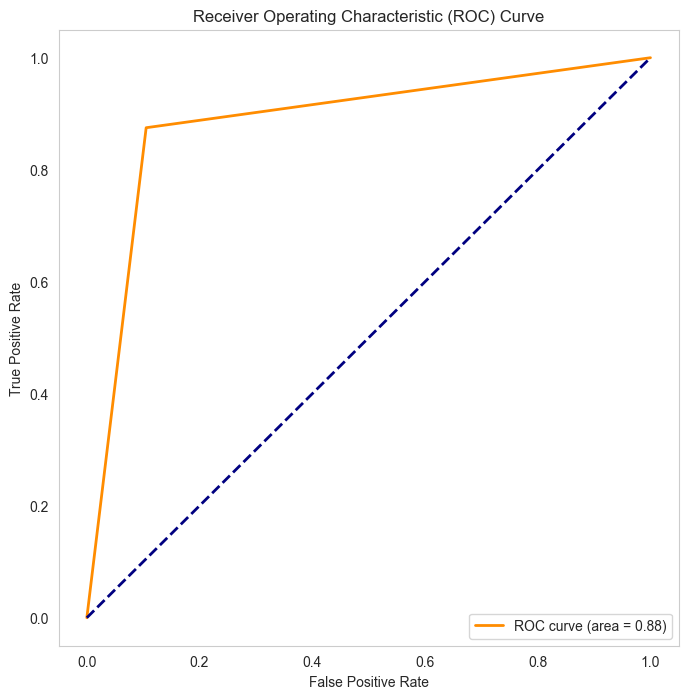

In [204]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_gb)
roc_auc = auc(fpr, tpr)
print("AUC:", roc_auc)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()